In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [2]:
boston = load_boston(return_X_y=False)
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=50)
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).view(-1,1)

X_train_mean = X_train.mean(0)
X_train_std = X_train.std(0)
X_train_norm = X_train.add(-1, X_train_mean) / X_train_std


y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)
y_train_norm = y_train.add(-1, y_train_mean) / y_train_std

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).view(-1,1)

# X_test_mean = X_test.mean(0)
# X_test_std = X_test.std(0)
# X_test_norm = X_test.add(-1, X_test_mean) / X_test_std


# y_test_mean = y_test.mean(0)
# y_test_std = y_test.std(0)
# y_test_norm = y_test.add(-1, y_test_mean) / y_test_std

In [3]:
train_data = torch.utils.data.TensorDataset(X_train_norm, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(13, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50,1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [ ]:
def logsumexp(a):
    a_max = a.max(axis=0)
    return np.log(np.sum(np.exp(a - a_max), axis=0)) + a_max

def test(Y_true, K_test, means, logvar):
    """
    Estimate predictive log likelihood:
    log p(y|x, D) = log int p(y|x, w) p(w|D) dw
                 ~= log int p(y|x, w) q(w) dw
                 ~= log 1/K sum p(y|x, w_k) with w_k sim q(w)
                  = LogSumExp log p(y|x, w_k) - log K
    :Y_true: a 2D array of size N x dim
    :MC_samples: a 3D array of size samples K x N x 2*D
    """
    k = K_test
    N = Y_true.shape[0]
    mean = means 
    logvar = logvar
    test_ll = -0.5 * np.exp(-logvar) * (mean - Y_val.squeeze())**2. - 0.5 * logvar - 0.5 * np.log(2 * np.pi) #Y_true[None]
    test_ll = np.sum(np.sum(test_ll, -1), -1)
    test_ll = logsumexp(test_ll) - np.log(k)
    pppp = test_ll / N  # per point predictive probability
    rmse = np.mean((np.mean(mean, 0) - Y_val.squeeze())**2.)**0.5
    return pppp, rmse

In [4]:
class evaluation(object):
    def __init__(self, test_data, std_true, X_mean=None, X_std=None, y_mean=None, y_std=None):
        self.test_data = test_data
        self.std_true = std_true
        self.X_mean = X_mean
        self.X_std = X_std
        self.y_mean = y_mean
        self.y_std = y_std
        self.n = 0
        self.avg_prediction = 0.
        self.sum_pp = 0.
        self.sumsqr_pp = 0.
        self.preds = torch.zeros(len(test_data.dataset),14000)

    def fn(self, model):

        with torch.autograd.no_grad():
            self.n += 1
            for x, y in iter(self.test_data):
                x = x.view(x.size(0), -1)

                if (self.X_mean is not None) & (self.X_std is not None):
                    x = (x - self.X_mean).float() / self.X_std

                standard_pred = model(x)

                if (self.y_mean is not None) & (self.y_std is not None):
                    standard_pred = standard_pred * self.y_std + self.y_mean
                
                self.preds[:,self.n-1] = standard_pred.view(-1,)
#                avg_pred = torch.mean(self.preds[:,:(self.n+1)].view(-1,self.n+1),1)
#                std_pred = torch.std(self.preds[:,:(self.n+1)].view(-1,self.n+1),1)
                self.avg_prediction = self.avg_prediction * (self.n - 1.) / self.n + standard_pred.view(-1,1) / self.n
#                std_pred = torch.std(y - self.avg_prediction)
                self.sum_pp += standard_pred
                self.sumsqr_pp += standard_pred * standard_pred
                std_pred = torch.sqrt((self.sumsqr_pp - (self.sum_pp * self.sum_pp) / self.n) / (self.n - 1))



                norm = torch.distributions.normal.Normal(y, std_pred)
                test_ll = norm.log_prob(self.avg_prediction).mean()



                error = nn.MSELoss(size_average=True)
                rmse = error(self.avg_prediction, y) ** 0.5
#                 test_ll = -0.5 * np.exp(-logvar) * (mean - Y_val.squeeze())**2. - 0.5 * logvar - 0.5 * np.log(2 * np.pi) #Y_true[None]
#                 test_ll = np.sum(np.sum(test_ll, -1), -1)
#                 test_ll = logsumexp(test_ll) - np.log(k)
#                 pppp = test_ll / N  # per point predictive probability
#                 rmse = np.mean((np.mean(mean, 0) - Y_val.squeeze())**2.)**0.5

                return rmse, test_ll, self.preds

In [5]:
def gelman_rubin(x, return_var=False):
    m, n = x.size()

    var_between = torch.sum((torch.mean(x, 1) - torch.mean(x)) ** 2) / (m - 1)
    x_bar = torch.mean(x, 1).view(-1,1)

    var_within = torch.sum((x - x_bar) ** 2) / (m * (n - 1))

    var = var_within * (n - 1) / n + var_between

    if return_var:
        return var

    V = var_within + var_between / n

    return torch.sqrt(V / var_within)

def ess(x):
    m, n = x.size()
    
    s_sq = gelman_rubin(x, return_var = True)
    
    neg_autocorr = False
    t = 1
    
    variogram = lambda t: (sum(sum((x[j][i] - x[j][i-t]) ** 2 for i in range(t,n)) for j in range(m)) / (m * (n - t)))
    
    rho = torch.ones(n)
    
    while not neg_autocorr and (t < n):
        rho[t] = 1. - variogram(t) / (2. * s_sq)
        
        if not t % 2:
            neg_autocorr = sum(rho[(t-1):(t+1)]) < 0
        t += 1
        
    return float(m * n)/ (1. + 2. * rho[1:t].sum())

In [8]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 8e-3



batch_size = 32.
dataset_size= 456.

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)

evaluate = evaluation(test_loader, 4.5, X_train_mean, X_train_std, y_train_mean, y_train_std)

losses_sgld = []
test_rmse = []
log_lik_sgld = []
t = 1.

for epoch in range(10000):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)

        network.zero_grad()
        output = network(x)
        loss = 0.5 * criterion(output, y)
        loss.backward()
        optim.step()


       
        running_loss += loss * batch_size / dataset_size


        if (t >= 1000) & (t % 100 == 0):
            rmse, log_lik, predictions = evaluate.fn(network)

#                rmse, log_lik = evaluate(network, test_loader, tau, T, y_train_mean, y_train_std)
            test_rmse.append(rmse)
            log_lik_sgld.append(log_lik)
        
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 0.4655
Epoch 1 - loss: 0.2825
Epoch 2 - loss: 0.2285
Epoch 3 - loss: 0.2076
Epoch 4 - loss: 0.1865
Epoch 5 - loss: 0.1702
Epoch 6 - loss: 0.1551
Epoch 7 - loss: 0.1482
Epoch 8 - loss: 0.1417
Epoch 9 - loss: 0.1408
Epoch 10 - loss: 0.1396
Epoch 11 - loss: 0.1399
Epoch 12 - loss: 0.1391
Epoch 13 - loss: 0.1379
Epoch 14 - loss: 0.1371
Epoch 15 - loss: 0.1391
Epoch 16 - loss: 0.1352
Epoch 17 - loss: 0.1306
Epoch 18 - loss: 0.1345
Epoch 19 - loss: 0.1340
Epoch 20 - loss: 0.1283
Epoch 21 - loss: 0.1283
Epoch 22 - loss: 0.1284
Epoch 23 - loss: 0.1216
Epoch 24 - loss: 0.1263
Epoch 25 - loss: 0.1284
Epoch 26 - loss: 0.1252
Epoch 27 - loss: 0.1232
Epoch 28 - loss: 0.1193
Epoch 29 - loss: 0.1184
Epoch 30 - loss: 0.1200
Epoch 31 - loss: 0.1130
Epoch 32 - loss: 0.1127
Epoch 33 - loss: 0.1098
Epoch 34 - loss: 0.1079
Epoch 35 - loss: 0.1125
Epoch 36 - loss: 0.1118
Epoch 37 - loss: 0.1091
Epoch 38 - loss: 0.1091
Epoch 39 - loss: 0.1180
Epoch 40 - loss: 0.1061
Epoch 41 - loss: 0.1052
Ep

Epoch 338 - loss: 0.0937
Epoch 339 - loss: 0.0821
Epoch 340 - loss: 0.0915
Epoch 341 - loss: 0.0866
Epoch 342 - loss: 0.0904
Epoch 343 - loss: 0.0858
Epoch 344 - loss: 0.0891
Epoch 345 - loss: 0.0913
Epoch 346 - loss: 0.1048
Epoch 347 - loss: 0.1011
Epoch 348 - loss: 0.0996
Epoch 349 - loss: 0.0964
Epoch 350 - loss: 0.1069
Epoch 351 - loss: 0.1002
Epoch 352 - loss: 0.1166
Epoch 353 - loss: 0.1058
Epoch 354 - loss: 0.1110
Epoch 355 - loss: 0.1085
Epoch 356 - loss: 0.1033
Epoch 357 - loss: 0.1110
Epoch 358 - loss: 0.0992
Epoch 359 - loss: 0.0961
Epoch 360 - loss: 0.1001
Epoch 361 - loss: 0.1010
Epoch 362 - loss: 0.1021
Epoch 363 - loss: 0.1079
Epoch 364 - loss: 0.1069
Epoch 365 - loss: 0.1166
Epoch 366 - loss: 0.1165
Epoch 367 - loss: 0.1186
Epoch 368 - loss: 0.1103
Epoch 369 - loss: 0.1100
Epoch 370 - loss: 0.1119
Epoch 371 - loss: 0.1388
Epoch 372 - loss: 0.1191
Epoch 373 - loss: 0.1006
Epoch 374 - loss: 0.1090
Epoch 375 - loss: 0.1083
Epoch 376 - loss: 0.1065
Epoch 377 - loss: 0.1007


Epoch 672 - loss: 0.2461
Epoch 673 - loss: 0.1300
Epoch 674 - loss: 0.1416
Epoch 675 - loss: 0.1346
Epoch 676 - loss: 0.1249
Epoch 677 - loss: 0.1394
Epoch 678 - loss: 0.1254
Epoch 679 - loss: 0.1174
Epoch 680 - loss: 0.1386
Epoch 681 - loss: 0.1030
Epoch 682 - loss: 0.1452
Epoch 683 - loss: 0.1156
Epoch 684 - loss: 0.1082
Epoch 685 - loss: 0.1196
Epoch 686 - loss: 0.1004
Epoch 687 - loss: 0.1032
Epoch 688 - loss: 0.1095
Epoch 689 - loss: 0.1108
Epoch 690 - loss: 0.1366
Epoch 691 - loss: 0.1229
Epoch 692 - loss: 0.1256
Epoch 693 - loss: 0.1309
Epoch 694 - loss: 0.1272
Epoch 695 - loss: 0.1374
Epoch 696 - loss: 0.1178
Epoch 697 - loss: 0.1208
Epoch 698 - loss: 0.1332
Epoch 699 - loss: 0.1141
Epoch 700 - loss: 0.1293
Epoch 701 - loss: 0.1508
Epoch 702 - loss: 0.1182
Epoch 703 - loss: 0.1414
Epoch 704 - loss: 0.1194
Epoch 705 - loss: 0.1421
Epoch 706 - loss: 0.1358
Epoch 707 - loss: 0.1419
Epoch 708 - loss: 0.1312
Epoch 709 - loss: 0.1232
Epoch 710 - loss: 0.1447
Epoch 711 - loss: 0.1464


Epoch 1002 - loss: 0.1021
Epoch 1003 - loss: 0.0981
Epoch 1004 - loss: 0.1132
Epoch 1005 - loss: 0.0928
Epoch 1006 - loss: 0.1118
Epoch 1007 - loss: 0.1183
Epoch 1008 - loss: 0.1118
Epoch 1009 - loss: 0.1668
Epoch 1010 - loss: 0.1154
Epoch 1011 - loss: 0.1038
Epoch 1012 - loss: 0.1111
Epoch 1013 - loss: 0.1227
Epoch 1014 - loss: 0.1298
Epoch 1015 - loss: 0.1353
Epoch 1016 - loss: 0.1244
Epoch 1017 - loss: 0.1077
Epoch 1018 - loss: 0.1093
Epoch 1019 - loss: 0.1098
Epoch 1020 - loss: 0.1078
Epoch 1021 - loss: 0.1139
Epoch 1022 - loss: 0.1065
Epoch 1023 - loss: 0.1078
Epoch 1024 - loss: 0.1265
Epoch 1025 - loss: 0.1309
Epoch 1026 - loss: 0.1191
Epoch 1027 - loss: 0.1192
Epoch 1028 - loss: 0.1629
Epoch 1029 - loss: 0.1246
Epoch 1030 - loss: 0.1379
Epoch 1031 - loss: 0.1209
Epoch 1032 - loss: 0.1431
Epoch 1033 - loss: 0.1145
Epoch 1034 - loss: 0.1633
Epoch 1035 - loss: 0.1253
Epoch 1036 - loss: 0.1201
Epoch 1037 - loss: 0.1106
Epoch 1038 - loss: 0.1535
Epoch 1039 - loss: 0.2475
Epoch 1040 -

Epoch 1319 - loss: 0.1084
Epoch 1320 - loss: 0.0983
Epoch 1321 - loss: 0.0966
Epoch 1322 - loss: 0.1001
Epoch 1323 - loss: 0.1099
Epoch 1324 - loss: 0.1596
Epoch 1325 - loss: 0.1508
Epoch 1326 - loss: 0.1202
Epoch 1327 - loss: 0.1741
Epoch 1328 - loss: 0.0970
Epoch 1329 - loss: 0.0934
Epoch 1330 - loss: 0.1161
Epoch 1331 - loss: 0.1085
Epoch 1332 - loss: 0.1035
Epoch 1333 - loss: 0.1156
Epoch 1334 - loss: 0.1112
Epoch 1335 - loss: 0.0922
Epoch 1336 - loss: 0.0902
Epoch 1337 - loss: 0.1124
Epoch 1338 - loss: 0.1151
Epoch 1339 - loss: 0.1123
Epoch 1340 - loss: 0.1112
Epoch 1341 - loss: 0.1103
Epoch 1342 - loss: 0.0996
Epoch 1343 - loss: 0.1246
Epoch 1344 - loss: 0.1838
Epoch 1345 - loss: 0.1568
Epoch 1346 - loss: 0.1280
Epoch 1347 - loss: 0.1073
Epoch 1348 - loss: 0.1863
Epoch 1349 - loss: 0.1398
Epoch 1350 - loss: 0.1476
Epoch 1351 - loss: 0.1249
Epoch 1352 - loss: 0.1520
Epoch 1353 - loss: 0.1026
Epoch 1354 - loss: 0.1987
Epoch 1355 - loss: 0.1583
Epoch 1356 - loss: 0.1766
Epoch 1357 -

Epoch 1637 - loss: 0.1452
Epoch 1638 - loss: 0.1299
Epoch 1639 - loss: 0.1713
Epoch 1640 - loss: 0.1442
Epoch 1641 - loss: 0.1132
Epoch 1642 - loss: 0.1259
Epoch 1643 - loss: 0.1086
Epoch 1644 - loss: 0.1116
Epoch 1645 - loss: 0.1140
Epoch 1646 - loss: 0.1402
Epoch 1647 - loss: 0.1457
Epoch 1648 - loss: 0.1355
Epoch 1649 - loss: 0.1085
Epoch 1650 - loss: 0.1193
Epoch 1651 - loss: 0.1233
Epoch 1652 - loss: 0.2601
Epoch 1653 - loss: 0.1118
Epoch 1654 - loss: 0.1424
Epoch 1655 - loss: 0.1141
Epoch 1656 - loss: 0.1189
Epoch 1657 - loss: 0.1384
Epoch 1658 - loss: 0.1228
Epoch 1659 - loss: 0.1174
Epoch 1660 - loss: 0.1120
Epoch 1661 - loss: 0.1425
Epoch 1662 - loss: 0.1411
Epoch 1663 - loss: 0.1519
Epoch 1664 - loss: 0.1550
Epoch 1665 - loss: 0.1194
Epoch 1666 - loss: 0.1385
Epoch 1667 - loss: 0.1361
Epoch 1668 - loss: 0.1410
Epoch 1669 - loss: 0.1646
Epoch 1670 - loss: 0.1380
Epoch 1671 - loss: 0.1600
Epoch 1672 - loss: 0.1327
Epoch 1673 - loss: 0.1257
Epoch 1674 - loss: 0.1395
Epoch 1675 -

Epoch 1957 - loss: 0.1098
Epoch 1958 - loss: 0.1016
Epoch 1959 - loss: 0.1144
Epoch 1960 - loss: 0.1115
Epoch 1961 - loss: 0.1113
Epoch 1962 - loss: 0.0923
Epoch 1963 - loss: 0.1105
Epoch 1964 - loss: 0.1466
Epoch 1965 - loss: 0.1578
Epoch 1966 - loss: 0.1427
Epoch 1967 - loss: 0.1199
Epoch 1968 - loss: 0.1121
Epoch 1969 - loss: 0.1078
Epoch 1970 - loss: 0.1016
Epoch 1971 - loss: 0.1058
Epoch 1972 - loss: 0.1008
Epoch 1973 - loss: 0.1099
Epoch 1974 - loss: 0.1088
Epoch 1975 - loss: 0.1141
Epoch 1976 - loss: 0.1092
Epoch 1977 - loss: 0.1190
Epoch 1978 - loss: 0.1079
Epoch 1979 - loss: 0.1113
Epoch 1980 - loss: 0.1056
Epoch 1981 - loss: 0.1110
Epoch 1982 - loss: 0.1255
Epoch 1983 - loss: 0.1205
Epoch 1984 - loss: 0.1190
Epoch 1985 - loss: 0.0997
Epoch 1986 - loss: 0.0970
Epoch 1987 - loss: 0.1022
Epoch 1988 - loss: 0.1125
Epoch 1989 - loss: 0.1084
Epoch 1990 - loss: 0.0952
Epoch 1991 - loss: 0.0989
Epoch 1992 - loss: 0.1230
Epoch 1993 - loss: 0.1323
Epoch 1994 - loss: 0.1335
Epoch 1995 -

Epoch 2273 - loss: 0.1163
Epoch 2274 - loss: 0.1148
Epoch 2275 - loss: 0.1089
Epoch 2276 - loss: 0.0929
Epoch 2277 - loss: 0.1060
Epoch 2278 - loss: 0.1342
Epoch 2279 - loss: 0.1200
Epoch 2280 - loss: 0.1012
Epoch 2281 - loss: 0.0989
Epoch 2282 - loss: 0.1176
Epoch 2283 - loss: 0.1137
Epoch 2284 - loss: 0.0954
Epoch 2285 - loss: 0.1110
Epoch 2286 - loss: 0.1260
Epoch 2287 - loss: 0.1078
Epoch 2288 - loss: 0.1495
Epoch 2289 - loss: 0.1052
Epoch 2290 - loss: 0.1201
Epoch 2291 - loss: 0.1296
Epoch 2292 - loss: 0.1017
Epoch 2293 - loss: 0.0969
Epoch 2294 - loss: 0.1012
Epoch 2295 - loss: 0.1183
Epoch 2296 - loss: 0.1025
Epoch 2297 - loss: 0.1481
Epoch 2298 - loss: 0.0986
Epoch 2299 - loss: 0.0847
Epoch 2300 - loss: 0.0941
Epoch 2301 - loss: 0.1070
Epoch 2302 - loss: 0.0974
Epoch 2303 - loss: 0.1044
Epoch 2304 - loss: 0.3061
Epoch 2305 - loss: 0.0853
Epoch 2306 - loss: 0.0890
Epoch 2307 - loss: 0.1263
Epoch 2308 - loss: 0.1013
Epoch 2309 - loss: 0.1130
Epoch 2310 - loss: 0.1088
Epoch 2311 -

Epoch 2592 - loss: 0.1423
Epoch 2593 - loss: 0.1124
Epoch 2594 - loss: 0.1230
Epoch 2595 - loss: 0.1193
Epoch 2596 - loss: 0.1181
Epoch 2597 - loss: 0.1521
Epoch 2598 - loss: 0.0964
Epoch 2599 - loss: 0.1029
Epoch 2600 - loss: 0.1324
Epoch 2601 - loss: 0.1003
Epoch 2602 - loss: 0.1545
Epoch 2603 - loss: 0.1125
Epoch 2604 - loss: 0.1049
Epoch 2605 - loss: 0.1253
Epoch 2606 - loss: 0.1113
Epoch 2607 - loss: 0.0935
Epoch 2608 - loss: 0.0954
Epoch 2609 - loss: 0.1043
Epoch 2610 - loss: 0.1024
Epoch 2611 - loss: 0.1405
Epoch 2612 - loss: 0.1263
Epoch 2613 - loss: 0.1133
Epoch 2614 - loss: 0.1292
Epoch 2615 - loss: 0.1118
Epoch 2616 - loss: 0.1128
Epoch 2617 - loss: 0.1177
Epoch 2618 - loss: 0.1067
Epoch 2619 - loss: 0.1008
Epoch 2620 - loss: 0.1090
Epoch 2621 - loss: 0.1136
Epoch 2622 - loss: 0.1281
Epoch 2623 - loss: 0.1084
Epoch 2624 - loss: 0.1124
Epoch 2625 - loss: 0.0944
Epoch 2626 - loss: 0.0968
Epoch 2627 - loss: 0.1057
Epoch 2628 - loss: 0.1308
Epoch 2629 - loss: 0.1237
Epoch 2630 -

Epoch 2917 - loss: 0.0995
Epoch 2918 - loss: 0.1033
Epoch 2919 - loss: 0.0902
Epoch 2920 - loss: 0.0952
Epoch 2921 - loss: 0.0948
Epoch 2922 - loss: 0.0926
Epoch 2923 - loss: 0.1018
Epoch 2924 - loss: 0.1032
Epoch 2925 - loss: 0.0950
Epoch 2926 - loss: 0.0944
Epoch 2927 - loss: 0.0873
Epoch 2928 - loss: 0.0884
Epoch 2929 - loss: 0.0806
Epoch 2930 - loss: 0.0935
Epoch 2931 - loss: 0.0979
Epoch 2932 - loss: 0.1294
Epoch 2933 - loss: 0.1077
Epoch 2934 - loss: 0.0925
Epoch 2935 - loss: 0.0898
Epoch 2936 - loss: 0.0854
Epoch 2937 - loss: 0.0926
Epoch 2938 - loss: 0.1006
Epoch 2939 - loss: 0.0956
Epoch 2940 - loss: 0.1061
Epoch 2941 - loss: 0.0977
Epoch 2942 - loss: 0.1166
Epoch 2943 - loss: 0.0908
Epoch 2944 - loss: 0.0973
Epoch 2945 - loss: 0.1112
Epoch 2946 - loss: 0.1024
Epoch 2947 - loss: 0.0907
Epoch 2948 - loss: 0.0944
Epoch 2949 - loss: 0.1128
Epoch 2950 - loss: 0.1232
Epoch 2951 - loss: 0.1132
Epoch 2952 - loss: 0.0985
Epoch 2953 - loss: 0.0906
Epoch 2954 - loss: 0.0975
Epoch 2955 -

Epoch 3236 - loss: 0.1020
Epoch 3237 - loss: 0.0997
Epoch 3238 - loss: 0.0888
Epoch 3239 - loss: 0.0935
Epoch 3240 - loss: 0.0945
Epoch 3241 - loss: 0.0934
Epoch 3242 - loss: 0.1033
Epoch 3243 - loss: 0.0955
Epoch 3244 - loss: 0.1029
Epoch 3245 - loss: 0.0964
Epoch 3246 - loss: 0.1052
Epoch 3247 - loss: 0.1009
Epoch 3248 - loss: 0.0940
Epoch 3249 - loss: 0.0946
Epoch 3250 - loss: 0.1082
Epoch 3251 - loss: 0.1018
Epoch 3252 - loss: 0.0962
Epoch 3253 - loss: 0.0911
Epoch 3254 - loss: 0.0864
Epoch 3255 - loss: 0.1023
Epoch 3256 - loss: 0.0821
Epoch 3257 - loss: 0.0974
Epoch 3258 - loss: 0.0895
Epoch 3259 - loss: 0.0901
Epoch 3260 - loss: 0.0828
Epoch 3261 - loss: 0.0851
Epoch 3262 - loss: 0.1005
Epoch 3263 - loss: 0.0958
Epoch 3264 - loss: 0.0952
Epoch 3265 - loss: 0.0868
Epoch 3266 - loss: 0.1003
Epoch 3267 - loss: 0.1039
Epoch 3268 - loss: 0.0973
Epoch 3269 - loss: 0.0935
Epoch 3270 - loss: 0.1007
Epoch 3271 - loss: 0.0922
Epoch 3272 - loss: 0.0946
Epoch 3273 - loss: 0.0923
Epoch 3274 -

Epoch 3553 - loss: 0.0841
Epoch 3554 - loss: 0.0833
Epoch 3555 - loss: 0.0819
Epoch 3556 - loss: 0.0809
Epoch 3557 - loss: 0.0863
Epoch 3558 - loss: 0.0774
Epoch 3559 - loss: 0.0783
Epoch 3560 - loss: 0.0763
Epoch 3561 - loss: 0.0828
Epoch 3562 - loss: 0.0829
Epoch 3563 - loss: 0.0740
Epoch 3564 - loss: 0.0835
Epoch 3565 - loss: 0.0786
Epoch 3566 - loss: 0.0798
Epoch 3567 - loss: 0.0773
Epoch 3568 - loss: 0.0764
Epoch 3569 - loss: 0.0777
Epoch 3570 - loss: 0.0857
Epoch 3571 - loss: 0.0759
Epoch 3572 - loss: 0.0790
Epoch 3573 - loss: 0.0820
Epoch 3574 - loss: 0.0793
Epoch 3575 - loss: 0.0903
Epoch 3576 - loss: 0.0788
Epoch 3577 - loss: 0.0813
Epoch 3578 - loss: 0.0769
Epoch 3579 - loss: 0.0769
Epoch 3580 - loss: 0.0734
Epoch 3581 - loss: 0.0764
Epoch 3582 - loss: 0.0689
Epoch 3583 - loss: 0.0717
Epoch 3584 - loss: 0.0728
Epoch 3585 - loss: 0.0785
Epoch 3586 - loss: 0.0778
Epoch 3587 - loss: 0.0820
Epoch 3588 - loss: 0.0789
Epoch 3589 - loss: 0.0811
Epoch 3590 - loss: 0.0794
Epoch 3591 -

Epoch 3873 - loss: 0.0907
Epoch 3874 - loss: 0.0978
Epoch 3875 - loss: 0.0819
Epoch 3876 - loss: 0.0799
Epoch 3877 - loss: 0.0763
Epoch 3878 - loss: 0.0737
Epoch 3879 - loss: 0.0812
Epoch 3880 - loss: 0.0806
Epoch 3881 - loss: 0.0848
Epoch 3882 - loss: 0.0835
Epoch 3883 - loss: 0.0753
Epoch 3884 - loss: 0.0791
Epoch 3885 - loss: 0.0727
Epoch 3886 - loss: 0.0773
Epoch 3887 - loss: 0.0823
Epoch 3888 - loss: 0.0768
Epoch 3889 - loss: 0.0844
Epoch 3890 - loss: 0.0803
Epoch 3891 - loss: 0.0869
Epoch 3892 - loss: 0.0841
Epoch 3893 - loss: 0.0897
Epoch 3894 - loss: 0.0853
Epoch 3895 - loss: 0.0903
Epoch 3896 - loss: 0.0779
Epoch 3897 - loss: 0.0971
Epoch 3898 - loss: 0.0778
Epoch 3899 - loss: 0.0763
Epoch 3900 - loss: 0.0756
Epoch 3901 - loss: 0.0810
Epoch 3902 - loss: 0.0834
Epoch 3903 - loss: 0.0910
Epoch 3904 - loss: 0.0887
Epoch 3905 - loss: 0.0848
Epoch 3906 - loss: 0.0891
Epoch 3907 - loss: 0.0779
Epoch 3908 - loss: 0.0800
Epoch 3909 - loss: 0.0806
Epoch 3910 - loss: 0.0822
Epoch 3911 -

Epoch 4193 - loss: 0.0802
Epoch 4194 - loss: 0.0745
Epoch 4195 - loss: 0.0731
Epoch 4196 - loss: 0.0778
Epoch 4197 - loss: 0.0810
Epoch 4198 - loss: 0.0778
Epoch 4199 - loss: 0.0877
Epoch 4200 - loss: 0.0854
Epoch 4201 - loss: 0.0845
Epoch 4202 - loss: 0.0803
Epoch 4203 - loss: 0.0875
Epoch 4204 - loss: 0.0920
Epoch 4205 - loss: 0.0975
Epoch 4206 - loss: 0.0933
Epoch 4207 - loss: 0.0911
Epoch 4208 - loss: 0.0872
Epoch 4209 - loss: 0.0804
Epoch 4210 - loss: 0.0852
Epoch 4211 - loss: 0.0847
Epoch 4212 - loss: 0.0882
Epoch 4213 - loss: 0.0876
Epoch 4214 - loss: 0.0951
Epoch 4215 - loss: 0.0927
Epoch 4216 - loss: 0.1000
Epoch 4217 - loss: 0.0907
Epoch 4218 - loss: 0.0819
Epoch 4219 - loss: 0.0830
Epoch 4220 - loss: 0.0986
Epoch 4221 - loss: 0.1018
Epoch 4222 - loss: 0.0909
Epoch 4223 - loss: 0.0902
Epoch 4224 - loss: 0.0982
Epoch 4225 - loss: 0.0987
Epoch 4226 - loss: 0.0912
Epoch 4227 - loss: 0.0993
Epoch 4228 - loss: 0.0960
Epoch 4229 - loss: 0.0993
Epoch 4230 - loss: 0.1014
Epoch 4231 -

Epoch 4509 - loss: 0.0949
Epoch 4510 - loss: 0.0923
Epoch 4511 - loss: 0.0868
Epoch 4512 - loss: 0.0923
Epoch 4513 - loss: 0.0949
Epoch 4514 - loss: 0.0889
Epoch 4515 - loss: 0.0821
Epoch 4516 - loss: 0.0801
Epoch 4517 - loss: 0.0858
Epoch 4518 - loss: 0.0858
Epoch 4519 - loss: 0.0886
Epoch 4520 - loss: 0.0857
Epoch 4521 - loss: 0.0900
Epoch 4522 - loss: 0.0939
Epoch 4523 - loss: 0.1015
Epoch 4524 - loss: 0.0918
Epoch 4525 - loss: 0.0975
Epoch 4526 - loss: 0.0983
Epoch 4527 - loss: 0.0976
Epoch 4528 - loss: 0.1044
Epoch 4529 - loss: 0.0971
Epoch 4530 - loss: 0.1029
Epoch 4531 - loss: 0.0918
Epoch 4532 - loss: 0.0971
Epoch 4533 - loss: 0.0967
Epoch 4534 - loss: 0.0910
Epoch 4535 - loss: 0.0886
Epoch 4536 - loss: 0.0964
Epoch 4537 - loss: 0.0860
Epoch 4538 - loss: 0.0948
Epoch 4539 - loss: 0.0897
Epoch 4540 - loss: 0.0946
Epoch 4541 - loss: 0.0960
Epoch 4542 - loss: 0.1052
Epoch 4543 - loss: 0.0804
Epoch 4544 - loss: 0.0911
Epoch 4545 - loss: 0.0959
Epoch 4546 - loss: 0.0957
Epoch 4547 -

Epoch 4825 - loss: 0.0982
Epoch 4826 - loss: 0.0855
Epoch 4827 - loss: 0.0865
Epoch 4828 - loss: 0.0860
Epoch 4829 - loss: 0.0765
Epoch 4830 - loss: 0.0786
Epoch 4831 - loss: 0.0867
Epoch 4832 - loss: 0.0895
Epoch 4833 - loss: 0.0976
Epoch 4834 - loss: 0.0887
Epoch 4835 - loss: 0.0853
Epoch 4836 - loss: 0.0918
Epoch 4837 - loss: 0.0935
Epoch 4838 - loss: 0.0914
Epoch 4839 - loss: 0.0851
Epoch 4840 - loss: 0.0801
Epoch 4841 - loss: 0.0914
Epoch 4842 - loss: 0.0909
Epoch 4843 - loss: 0.0900
Epoch 4844 - loss: 0.0858
Epoch 4845 - loss: 0.0837
Epoch 4846 - loss: 0.0834
Epoch 4847 - loss: 0.0963
Epoch 4848 - loss: 0.0936
Epoch 4849 - loss: 0.0969
Epoch 4850 - loss: 0.0902
Epoch 4851 - loss: 0.0811
Epoch 4852 - loss: 0.0960
Epoch 4853 - loss: 0.0836
Epoch 4854 - loss: 0.0926
Epoch 4855 - loss: 0.0935
Epoch 4856 - loss: 0.0837
Epoch 4857 - loss: 0.0862
Epoch 4858 - loss: 0.0802
Epoch 4859 - loss: 0.0800
Epoch 4860 - loss: 0.0858
Epoch 4861 - loss: 0.0827
Epoch 4862 - loss: 0.0912
Epoch 4863 -

Epoch 5145 - loss: 0.1052
Epoch 5146 - loss: 0.1518
Epoch 5147 - loss: 0.1041
Epoch 5148 - loss: 0.1063
Epoch 5149 - loss: 0.0917
Epoch 5150 - loss: 0.0954
Epoch 5151 - loss: 0.0917
Epoch 5152 - loss: 0.1002
Epoch 5153 - loss: 0.0894
Epoch 5154 - loss: 0.1021
Epoch 5155 - loss: 0.1429
Epoch 5156 - loss: 0.1058
Epoch 5157 - loss: 0.0910
Epoch 5158 - loss: 0.2209
Epoch 5159 - loss: 0.1064
Epoch 5160 - loss: 0.1372
Epoch 5161 - loss: 0.1399
Epoch 5162 - loss: 0.1623
Epoch 5163 - loss: 0.1059
Epoch 5164 - loss: 0.1150
Epoch 5165 - loss: 0.1006
Epoch 5166 - loss: 0.1064
Epoch 5167 - loss: 0.1062
Epoch 5168 - loss: 0.1227
Epoch 5169 - loss: 0.1111
Epoch 5170 - loss: 0.1180
Epoch 5171 - loss: 0.0916
Epoch 5172 - loss: 0.1194
Epoch 5173 - loss: 0.1682
Epoch 5174 - loss: 0.1296
Epoch 5175 - loss: 0.1731
Epoch 5176 - loss: 0.1433
Epoch 5177 - loss: 0.1139
Epoch 5178 - loss: 0.1148
Epoch 5179 - loss: 0.1069
Epoch 5180 - loss: 0.1219
Epoch 5181 - loss: 0.1188
Epoch 5182 - loss: 0.1315
Epoch 5183 -

Epoch 5463 - loss: 0.0971
Epoch 5464 - loss: 0.1056
Epoch 5465 - loss: 0.1079
Epoch 5466 - loss: 0.1072
Epoch 5467 - loss: 0.0943
Epoch 5468 - loss: 0.0950
Epoch 5469 - loss: 0.1011
Epoch 5470 - loss: 0.0897
Epoch 5471 - loss: 0.0993
Epoch 5472 - loss: 0.1039
Epoch 5473 - loss: 0.0955
Epoch 5474 - loss: 0.0998
Epoch 5475 - loss: 0.0968
Epoch 5476 - loss: 0.0897
Epoch 5477 - loss: 0.0959
Epoch 5478 - loss: 0.0980
Epoch 5479 - loss: 0.0917
Epoch 5480 - loss: 0.0851
Epoch 5481 - loss: 0.0934
Epoch 5482 - loss: 0.0857
Epoch 5483 - loss: 0.0820
Epoch 5484 - loss: 0.0982
Epoch 5485 - loss: 0.0937
Epoch 5486 - loss: 0.0879
Epoch 5487 - loss: 0.0976
Epoch 5488 - loss: 0.0924
Epoch 5489 - loss: 0.0897
Epoch 5490 - loss: 0.0911
Epoch 5491 - loss: 0.1083
Epoch 5492 - loss: 0.1069
Epoch 5493 - loss: 0.0886
Epoch 5494 - loss: 0.0899
Epoch 5495 - loss: 0.0833
Epoch 5496 - loss: 0.0926
Epoch 5497 - loss: 0.0972
Epoch 5498 - loss: 0.0866
Epoch 5499 - loss: 0.0968
Epoch 5500 - loss: 0.0940
Epoch 5501 -

Epoch 5787 - loss: 0.1259
Epoch 5788 - loss: 0.1075
Epoch 5789 - loss: 0.1140
Epoch 5790 - loss: 0.1091
Epoch 5791 - loss: 0.1094
Epoch 5792 - loss: 0.1045
Epoch 5793 - loss: 0.1018
Epoch 5794 - loss: 0.0863
Epoch 5795 - loss: 0.1027
Epoch 5796 - loss: 0.0954
Epoch 5797 - loss: 0.0831
Epoch 5798 - loss: 0.0892
Epoch 5799 - loss: 0.0915
Epoch 5800 - loss: 0.1051
Epoch 5801 - loss: 0.1009
Epoch 5802 - loss: 0.1046
Epoch 5803 - loss: 0.1026
Epoch 5804 - loss: 0.0953
Epoch 5805 - loss: 0.0890
Epoch 5806 - loss: 0.0932
Epoch 5807 - loss: 0.0861
Epoch 5808 - loss: 0.0811
Epoch 5809 - loss: 0.0837
Epoch 5810 - loss: 0.1082
Epoch 5811 - loss: 0.1120
Epoch 5812 - loss: 0.1095
Epoch 5813 - loss: 0.0949
Epoch 5814 - loss: 0.0934
Epoch 5815 - loss: 0.0956
Epoch 5816 - loss: 0.0864
Epoch 5817 - loss: 0.0951
Epoch 5818 - loss: 0.0905
Epoch 5819 - loss: 0.0843
Epoch 5820 - loss: 0.0926
Epoch 5821 - loss: 0.0883
Epoch 5822 - loss: 0.0919
Epoch 5823 - loss: 0.0941
Epoch 5824 - loss: 0.0835
Epoch 5825 -

Epoch 6107 - loss: 0.0830
Epoch 6108 - loss: 0.0860
Epoch 6109 - loss: 0.0904
Epoch 6110 - loss: 0.0946
Epoch 6111 - loss: 0.0920
Epoch 6112 - loss: 0.0882
Epoch 6113 - loss: 0.1020
Epoch 6114 - loss: 0.0881
Epoch 6115 - loss: 0.0933
Epoch 6116 - loss: 0.0918
Epoch 6117 - loss: 0.0929
Epoch 6118 - loss: 0.0954
Epoch 6119 - loss: 0.1012
Epoch 6120 - loss: 0.0885
Epoch 6121 - loss: 0.0857
Epoch 6122 - loss: 0.0983
Epoch 6123 - loss: 0.0859
Epoch 6124 - loss: 0.0824
Epoch 6125 - loss: 0.0884
Epoch 6126 - loss: 0.0828
Epoch 6127 - loss: 0.0946
Epoch 6128 - loss: 0.0913
Epoch 6129 - loss: 0.1035
Epoch 6130 - loss: 0.0826
Epoch 6131 - loss: 0.0768
Epoch 6132 - loss: 0.1031
Epoch 6133 - loss: 0.0875
Epoch 6134 - loss: 0.0852
Epoch 6135 - loss: 0.1524
Epoch 6136 - loss: 0.0989
Epoch 6137 - loss: 0.0844
Epoch 6138 - loss: 0.0833
Epoch 6139 - loss: 0.0873
Epoch 6140 - loss: 0.0948
Epoch 6141 - loss: 0.0907
Epoch 6142 - loss: 0.0891
Epoch 6143 - loss: 0.0902
Epoch 6144 - loss: 0.0886
Epoch 6145 -

Epoch 6424 - loss: 0.1048
Epoch 6425 - loss: 0.0991
Epoch 6426 - loss: 0.0863
Epoch 6427 - loss: 0.0818
Epoch 6428 - loss: 0.0951
Epoch 6429 - loss: 0.0918
Epoch 6430 - loss: 0.0874
Epoch 6431 - loss: 0.0993
Epoch 6432 - loss: 0.0863
Epoch 6433 - loss: 0.1200
Epoch 6434 - loss: 0.0901
Epoch 6435 - loss: 0.0957
Epoch 6436 - loss: 0.0877
Epoch 6437 - loss: 0.0907
Epoch 6438 - loss: 0.0830
Epoch 6439 - loss: 0.0858
Epoch 6440 - loss: 0.1072
Epoch 6441 - loss: 0.0947
Epoch 6442 - loss: 0.0880
Epoch 6443 - loss: 0.0850
Epoch 6444 - loss: 0.0906
Epoch 6445 - loss: 0.0841
Epoch 6446 - loss: 0.0965
Epoch 6447 - loss: 0.0947
Epoch 6448 - loss: 0.0878
Epoch 6449 - loss: 0.0844
Epoch 6450 - loss: 0.0917
Epoch 6451 - loss: 0.0886
Epoch 6452 - loss: 0.0966
Epoch 6453 - loss: 0.1064
Epoch 6454 - loss: 0.0957
Epoch 6455 - loss: 0.1196
Epoch 6456 - loss: 0.0869
Epoch 6457 - loss: 0.0854
Epoch 6458 - loss: 0.0919
Epoch 6459 - loss: 0.0826
Epoch 6460 - loss: 0.0934
Epoch 6461 - loss: 0.1224
Epoch 6462 -

Epoch 6745 - loss: 0.0791
Epoch 6746 - loss: 0.0801
Epoch 6747 - loss: 0.0775
Epoch 6748 - loss: 0.0813
Epoch 6749 - loss: 0.0816
Epoch 6750 - loss: 0.0840
Epoch 6751 - loss: 0.0777
Epoch 6752 - loss: 0.0785
Epoch 6753 - loss: 0.0807
Epoch 6754 - loss: 0.0845
Epoch 6755 - loss: 0.0790
Epoch 6756 - loss: 0.0837
Epoch 6757 - loss: 0.0821
Epoch 6758 - loss: 0.0843
Epoch 6759 - loss: 0.0815
Epoch 6760 - loss: 0.0869
Epoch 6761 - loss: 0.0860
Epoch 6762 - loss: 0.0875
Epoch 6763 - loss: 0.0827
Epoch 6764 - loss: 0.0872
Epoch 6765 - loss: 0.0848
Epoch 6766 - loss: 0.0790
Epoch 6767 - loss: 0.0807
Epoch 6768 - loss: 0.0817
Epoch 6769 - loss: 0.0803
Epoch 6770 - loss: 0.0841
Epoch 6771 - loss: 0.0848
Epoch 6772 - loss: 0.0864
Epoch 6773 - loss: 0.0847
Epoch 6774 - loss: 0.0795
Epoch 6775 - loss: 0.0828
Epoch 6776 - loss: 0.0809
Epoch 6777 - loss: 0.0832
Epoch 6778 - loss: 0.0799
Epoch 6779 - loss: 0.0840
Epoch 6780 - loss: 0.0805
Epoch 6781 - loss: 0.0789
Epoch 6782 - loss: 0.0784
Epoch 6783 -

Epoch 7061 - loss: 0.0822
Epoch 7062 - loss: 0.0964
Epoch 7063 - loss: 0.1185
Epoch 7064 - loss: 0.0936
Epoch 7065 - loss: 0.1055
Epoch 7066 - loss: 0.1073
Epoch 7067 - loss: 0.1023
Epoch 7068 - loss: 0.0908
Epoch 7069 - loss: 0.0861
Epoch 7070 - loss: 0.0898
Epoch 7071 - loss: 0.0937
Epoch 7072 - loss: 0.0860
Epoch 7073 - loss: 0.0849
Epoch 7074 - loss: 0.0855
Epoch 7075 - loss: 0.0992
Epoch 7076 - loss: 0.0879
Epoch 7077 - loss: 0.0922
Epoch 7078 - loss: 0.0877
Epoch 7079 - loss: 0.0908
Epoch 7080 - loss: 0.0907
Epoch 7081 - loss: 0.0828
Epoch 7082 - loss: 0.0786
Epoch 7083 - loss: 0.0786
Epoch 7084 - loss: 0.0936
Epoch 7085 - loss: 0.1020
Epoch 7086 - loss: 0.0959
Epoch 7087 - loss: 0.0865
Epoch 7088 - loss: 0.0956
Epoch 7089 - loss: 0.0850
Epoch 7090 - loss: 0.0920
Epoch 7091 - loss: 0.1105
Epoch 7092 - loss: 0.1091
Epoch 7093 - loss: 0.1079
Epoch 7094 - loss: 0.0910
Epoch 7095 - loss: 0.0933
Epoch 7096 - loss: 0.0967
Epoch 7097 - loss: 0.0931
Epoch 7098 - loss: 0.1067
Epoch 7099 -

Epoch 7383 - loss: 0.0938
Epoch 7384 - loss: 0.0851
Epoch 7385 - loss: 0.0817
Epoch 7386 - loss: 0.0894
Epoch 7387 - loss: 0.0803
Epoch 7388 - loss: 0.0856
Epoch 7389 - loss: 0.0839
Epoch 7390 - loss: 0.0842
Epoch 7391 - loss: 0.0797
Epoch 7392 - loss: 0.0853
Epoch 7393 - loss: 0.0865
Epoch 7394 - loss: 0.0878
Epoch 7395 - loss: 0.0920
Epoch 7396 - loss: 0.0929
Epoch 7397 - loss: 0.0918
Epoch 7398 - loss: 0.0898
Epoch 7399 - loss: 0.0911
Epoch 7400 - loss: 0.0835
Epoch 7401 - loss: 0.0810
Epoch 7402 - loss: 0.0795
Epoch 7403 - loss: 0.0827
Epoch 7404 - loss: 0.0830
Epoch 7405 - loss: 0.0829
Epoch 7406 - loss: 0.0943
Epoch 7407 - loss: 0.0858
Epoch 7408 - loss: 0.0847
Epoch 7409 - loss: 0.0854
Epoch 7410 - loss: 0.0781
Epoch 7411 - loss: 0.0830
Epoch 7412 - loss: 0.0788
Epoch 7413 - loss: 0.0771
Epoch 7414 - loss: 0.0820
Epoch 7415 - loss: 0.0843
Epoch 7416 - loss: 0.0788
Epoch 7417 - loss: 0.0762
Epoch 7418 - loss: 0.0756
Epoch 7419 - loss: 0.0765
Epoch 7420 - loss: 0.0798
Epoch 7421 -

Epoch 7703 - loss: 0.0804
Epoch 7704 - loss: 0.0827
Epoch 7705 - loss: 0.0783
Epoch 7706 - loss: 0.0771
Epoch 7707 - loss: 0.0792
Epoch 7708 - loss: 0.0859
Epoch 7709 - loss: 0.0800
Epoch 7710 - loss: 0.0747
Epoch 7711 - loss: 0.0804
Epoch 7712 - loss: 0.0767
Epoch 7713 - loss: 0.0699
Epoch 7714 - loss: 0.0759
Epoch 7715 - loss: 0.0774
Epoch 7716 - loss: 0.0755
Epoch 7717 - loss: 0.0833
Epoch 7718 - loss: 0.0792
Epoch 7719 - loss: 0.0752
Epoch 7720 - loss: 0.0774
Epoch 7721 - loss: 0.0729
Epoch 7722 - loss: 0.0712
Epoch 7723 - loss: 0.0741
Epoch 7724 - loss: 0.0691
Epoch 7725 - loss: 0.0757
Epoch 7726 - loss: 0.0702
Epoch 7727 - loss: 0.0696
Epoch 7728 - loss: 0.0701
Epoch 7729 - loss: 0.0716
Epoch 7730 - loss: 0.0718
Epoch 7731 - loss: 0.0699
Epoch 7732 - loss: 0.0684
Epoch 7733 - loss: 0.0716
Epoch 7734 - loss: 0.0696
Epoch 7735 - loss: 0.0693
Epoch 7736 - loss: 0.0760
Epoch 7737 - loss: 0.0781
Epoch 7738 - loss: 0.0746
Epoch 7739 - loss: 0.0785
Epoch 7740 - loss: 0.0746
Epoch 7741 -

Epoch 8022 - loss: 0.0757
Epoch 8023 - loss: 0.0771
Epoch 8024 - loss: 0.0779
Epoch 8025 - loss: 0.0716
Epoch 8026 - loss: 0.0741
Epoch 8027 - loss: 0.0769
Epoch 8028 - loss: 0.0761
Epoch 8029 - loss: 0.0744
Epoch 8030 - loss: 0.0785
Epoch 8031 - loss: 0.0739
Epoch 8032 - loss: 0.0754
Epoch 8033 - loss: 0.0718
Epoch 8034 - loss: 0.0715
Epoch 8035 - loss: 0.0762
Epoch 8036 - loss: 0.0752
Epoch 8037 - loss: 0.0730
Epoch 8038 - loss: 0.0809
Epoch 8039 - loss: 0.0772
Epoch 8040 - loss: 0.0767
Epoch 8041 - loss: 0.0760
Epoch 8042 - loss: 0.0733
Epoch 8043 - loss: 0.0811
Epoch 8044 - loss: 0.0784
Epoch 8045 - loss: 0.0784
Epoch 8046 - loss: 0.0738
Epoch 8047 - loss: 0.0724
Epoch 8048 - loss: 0.0706
Epoch 8049 - loss: 0.0707
Epoch 8050 - loss: 0.0764
Epoch 8051 - loss: 0.0803
Epoch 8052 - loss: 0.0773
Epoch 8053 - loss: 0.0747
Epoch 8054 - loss: 0.0789
Epoch 8055 - loss: 0.0771
Epoch 8056 - loss: 0.0828
Epoch 8057 - loss: 0.0857
Epoch 8058 - loss: 0.0878
Epoch 8059 - loss: 0.0915
Epoch 8060 -

Epoch 8339 - loss: 0.0765
Epoch 8340 - loss: 0.0754
Epoch 8341 - loss: 0.0798
Epoch 8342 - loss: 0.0796
Epoch 8343 - loss: 0.0749
Epoch 8344 - loss: 0.0796
Epoch 8345 - loss: 0.0719
Epoch 8346 - loss: 0.0764
Epoch 8347 - loss: 0.0762
Epoch 8348 - loss: 0.0749
Epoch 8349 - loss: 0.0827
Epoch 8350 - loss: 0.0838
Epoch 8351 - loss: 0.0796
Epoch 8352 - loss: 0.0792
Epoch 8353 - loss: 0.0775
Epoch 8354 - loss: 0.0748
Epoch 8355 - loss: 0.0770
Epoch 8356 - loss: 0.0797
Epoch 8357 - loss: 0.0817
Epoch 8358 - loss: 0.0856
Epoch 8359 - loss: 0.0870
Epoch 8360 - loss: 0.0777
Epoch 8361 - loss: 0.0855
Epoch 8362 - loss: 0.0825
Epoch 8363 - loss: 0.0826
Epoch 8364 - loss: 0.0820
Epoch 8365 - loss: 0.0810
Epoch 8366 - loss: 0.0815
Epoch 8367 - loss: 0.0829
Epoch 8368 - loss: 0.0817
Epoch 8369 - loss: 0.0888
Epoch 8370 - loss: 0.0811
Epoch 8371 - loss: 0.0803
Epoch 8372 - loss: 0.0874
Epoch 8373 - loss: 0.0908
Epoch 8374 - loss: 0.0857
Epoch 8375 - loss: 0.0905
Epoch 8376 - loss: 0.0858
Epoch 8377 -

Epoch 8656 - loss: 0.0832
Epoch 8657 - loss: 0.0809
Epoch 8658 - loss: 0.0780
Epoch 8659 - loss: 0.0777
Epoch 8660 - loss: 0.0772
Epoch 8661 - loss: 0.0767
Epoch 8662 - loss: 0.0760
Epoch 8663 - loss: 0.0734
Epoch 8664 - loss: 0.0696
Epoch 8665 - loss: 0.0720
Epoch 8666 - loss: 0.0735
Epoch 8667 - loss: 0.0742
Epoch 8668 - loss: 0.0766
Epoch 8669 - loss: 0.0742
Epoch 8670 - loss: 0.0808
Epoch 8671 - loss: 0.0799
Epoch 8672 - loss: 0.0759
Epoch 8673 - loss: 0.0775
Epoch 8674 - loss: 0.0823
Epoch 8675 - loss: 0.0809
Epoch 8676 - loss: 0.0752
Epoch 8677 - loss: 0.0742
Epoch 8678 - loss: 0.0756
Epoch 8679 - loss: 0.0806
Epoch 8680 - loss: 0.0782
Epoch 8681 - loss: 0.0759
Epoch 8682 - loss: 0.0735
Epoch 8683 - loss: 0.0742
Epoch 8684 - loss: 0.0753
Epoch 8685 - loss: 0.0807
Epoch 8686 - loss: 0.0756
Epoch 8687 - loss: 0.0759
Epoch 8688 - loss: 0.0773
Epoch 8689 - loss: 0.0764
Epoch 8690 - loss: 0.0769
Epoch 8691 - loss: 0.0785
Epoch 8692 - loss: 0.0779
Epoch 8693 - loss: 0.0755
Epoch 8694 -

Epoch 8974 - loss: 0.0776
Epoch 8975 - loss: 0.0721
Epoch 8976 - loss: 0.0796
Epoch 8977 - loss: 0.0786
Epoch 8978 - loss: 0.0733
Epoch 8979 - loss: 0.0727
Epoch 8980 - loss: 0.0756
Epoch 8981 - loss: 0.0769
Epoch 8982 - loss: 0.0708
Epoch 8983 - loss: 0.0707
Epoch 8984 - loss: 0.0715
Epoch 8985 - loss: 0.0715
Epoch 8986 - loss: 0.0736
Epoch 8987 - loss: 0.0750
Epoch 8988 - loss: 0.0777
Epoch 8989 - loss: 0.0775
Epoch 8990 - loss: 0.0766
Epoch 8991 - loss: 0.0774
Epoch 8992 - loss: 0.0769
Epoch 8993 - loss: 0.0831
Epoch 8994 - loss: 0.0799
Epoch 8995 - loss: 0.0800
Epoch 8996 - loss: 0.0832
Epoch 8997 - loss: 0.0749
Epoch 8998 - loss: 0.0782
Epoch 8999 - loss: 0.0783
Epoch 9000 - loss: 0.0801
Epoch 9001 - loss: 0.0778
Epoch 9002 - loss: 0.0694
Epoch 9003 - loss: 0.0713
Epoch 9004 - loss: 0.0728
Epoch 9005 - loss: 0.0731
Epoch 9006 - loss: 0.0741
Epoch 9007 - loss: 0.0735
Epoch 9008 - loss: 0.0726
Epoch 9009 - loss: 0.0737
Epoch 9010 - loss: 0.0712
Epoch 9011 - loss: 0.0707
Epoch 9012 -

Epoch 9290 - loss: 0.0724
Epoch 9291 - loss: 0.0722
Epoch 9292 - loss: 0.0706
Epoch 9293 - loss: 0.0739
Epoch 9294 - loss: 0.0705
Epoch 9295 - loss: 0.0752
Epoch 9296 - loss: 0.0703
Epoch 9297 - loss: 0.0770
Epoch 9298 - loss: 0.0722
Epoch 9299 - loss: 0.0682
Epoch 9300 - loss: 0.0693
Epoch 9301 - loss: 0.0687
Epoch 9302 - loss: 0.0729
Epoch 9303 - loss: 0.0786
Epoch 9304 - loss: 0.0803
Epoch 9305 - loss: 0.0771
Epoch 9306 - loss: 0.0756
Epoch 9307 - loss: 0.0780
Epoch 9308 - loss: 0.0816
Epoch 9309 - loss: 0.0763
Epoch 9310 - loss: 0.0771
Epoch 9311 - loss: 0.0733
Epoch 9312 - loss: 0.0750
Epoch 9313 - loss: 0.0754
Epoch 9314 - loss: 0.0736
Epoch 9315 - loss: 0.0685
Epoch 9316 - loss: 0.0702
Epoch 9317 - loss: 0.0723
Epoch 9318 - loss: 0.0695
Epoch 9319 - loss: 0.0688
Epoch 9320 - loss: 0.0673
Epoch 9321 - loss: 0.0719
Epoch 9322 - loss: 0.0762
Epoch 9323 - loss: 0.0708
Epoch 9324 - loss: 0.0701
Epoch 9325 - loss: 0.0692
Epoch 9326 - loss: 0.0695
Epoch 9327 - loss: 0.0746
Epoch 9328 -

Epoch 9611 - loss: 0.0705
Epoch 9612 - loss: 0.0674
Epoch 9613 - loss: 0.0689
Epoch 9614 - loss: 0.0708
Epoch 9615 - loss: 0.0684
Epoch 9616 - loss: 0.0702
Epoch 9617 - loss: 0.0681
Epoch 9618 - loss: 0.0698
Epoch 9619 - loss: 0.0696
Epoch 9620 - loss: 0.0657
Epoch 9621 - loss: 0.0676
Epoch 9622 - loss: 0.0690
Epoch 9623 - loss: 0.0698
Epoch 9624 - loss: 0.0670
Epoch 9625 - loss: 0.0692
Epoch 9626 - loss: 0.0723
Epoch 9627 - loss: 0.0659
Epoch 9628 - loss: 0.0649
Epoch 9629 - loss: 0.0620
Epoch 9630 - loss: 0.0644
Epoch 9631 - loss: 0.0645
Epoch 9632 - loss: 0.0662
Epoch 9633 - loss: 0.0636
Epoch 9634 - loss: 0.0611
Epoch 9635 - loss: 0.0698
Epoch 9636 - loss: 0.0653
Epoch 9637 - loss: 0.0681
Epoch 9638 - loss: 0.0676
Epoch 9639 - loss: 0.0672
Epoch 9640 - loss: 0.0674
Epoch 9641 - loss: 0.0686
Epoch 9642 - loss: 0.0631
Epoch 9643 - loss: 0.0637
Epoch 9644 - loss: 0.0662
Epoch 9645 - loss: 0.0649
Epoch 9646 - loss: 0.0728
Epoch 9647 - loss: 0.0646
Epoch 9648 - loss: 0.0652
Epoch 9649 -

Epoch 9929 - loss: 0.0720
Epoch 9930 - loss: 0.0771
Epoch 9931 - loss: 0.0710
Epoch 9932 - loss: 0.0762
Epoch 9933 - loss: 0.0726
Epoch 9934 - loss: 0.0753
Epoch 9935 - loss: 0.0746
Epoch 9936 - loss: 0.0774
Epoch 9937 - loss: 0.0756
Epoch 9938 - loss: 0.0746
Epoch 9939 - loss: 0.0750
Epoch 9940 - loss: 0.0731
Epoch 9941 - loss: 0.0718
Epoch 9942 - loss: 0.0793
Epoch 9943 - loss: 0.0802
Epoch 9944 - loss: 0.0803
Epoch 9945 - loss: 0.0793
Epoch 9946 - loss: 0.0816
Epoch 9947 - loss: 0.0779
Epoch 9948 - loss: 0.0789
Epoch 9949 - loss: 0.0873
Epoch 9950 - loss: 0.0803
Epoch 9951 - loss: 0.0800
Epoch 9952 - loss: 0.0798
Epoch 9953 - loss: 0.0811
Epoch 9954 - loss: 0.0802
Epoch 9955 - loss: 0.0782
Epoch 9956 - loss: 0.0771
Epoch 9957 - loss: 0.0798
Epoch 9958 - loss: 0.0801
Epoch 9959 - loss: 0.0773
Epoch 9960 - loss: 0.0787
Epoch 9961 - loss: 0.0766
Epoch 9962 - loss: 0.0759
Epoch 9963 - loss: 0.0759
Epoch 9964 - loss: 0.0744
Epoch 9965 - loss: 0.0744
Epoch 9966 - loss: 0.0753
Epoch 9967 -

In [9]:
gelman_rubin(predictions[:,:1491])

tensor(1.0009)

In [ ]:
ess(predictions)

In [10]:
np.max(log_lik_sgld[2:])

-2.4898887

In [11]:
log_lik_sgld[-1]

tensor(-2.4899)

(-8, 0)

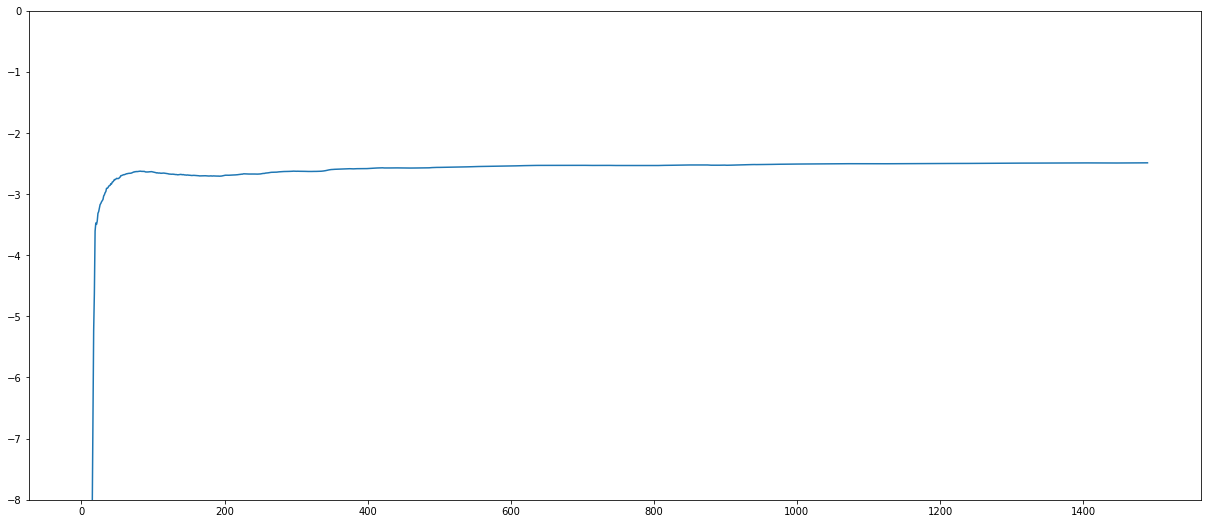

In [12]:
plt.figure(figsize=(21,9))
plt.plot(range(1491),log_lik_sgld)
plt.ylim(-8,0)

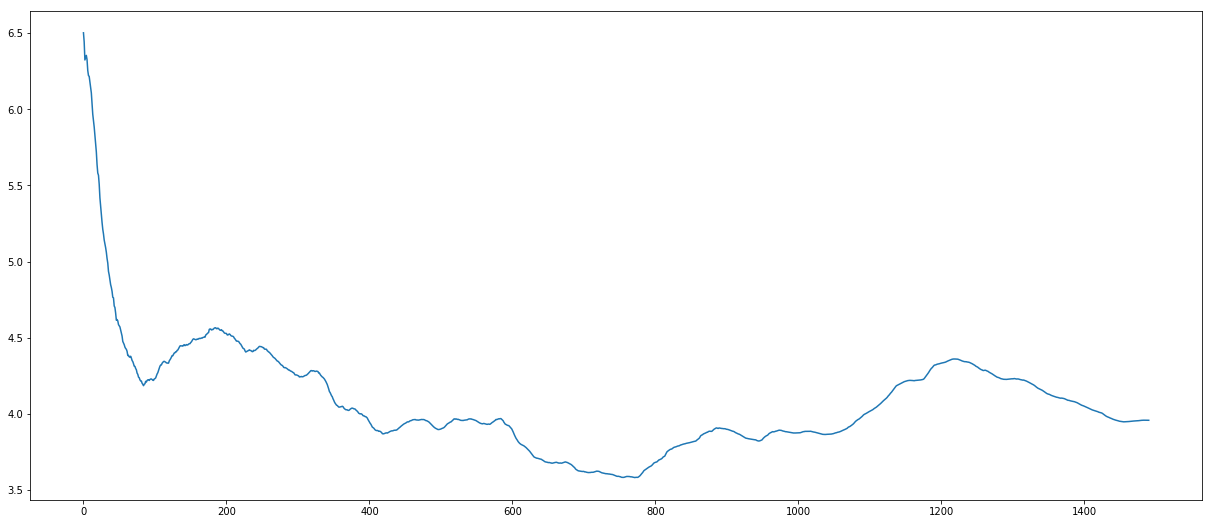

In [13]:
plt.figure(figsize=(21,9))
plt.plot(range(1491),test_rmse)

### SGFS

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import chain

class mlp(nn.Module):
    """
    "Standard" MLP with support with goodfellow's backprop trick
    """
    def __init__(self, architecture, nl=F.relu):
        super(mlp, self).__init__()

        self.nl = nl
        self.hidden_layers = nn.ModuleList([nn.Linear(architecture[i-1], architecture[i], bias=False) for i in range(1, len(architecture) - 1)])
        #nonlinearities = nn.ModuleList([nn.ReLU() for _ in self.hidden_layers])
        #interleaved = chain.from_iterable(zip(self.hidden_layers, nonlinearities))
        self.output_layer = nn.Linear(architecture[-2], architecture[-1], bias=False)


    def forward(self, x):
        """
        Forward pass that returns also returns
        * the activations (H) and
        * the linear combinations (Z)
        of each layer, to be able to use the trick from [1].

        Args:
            - x : The inputs of the network
        Returns:
            - logits
            - activations at each layer (including the inputs)
            - linear combinations at each layer
        > [1] EFFICIENT PER-EXAMPLE GRADIENT COMPUTATIONS
        > by Ian Goodfellow
        > https://arxiv.org/pdf/1510.01799.pdf
        """
        x = x.view(x.size(0), -1)

        # Save the model inputs, which are considered the activations of the 0'th layer.
        activations = [x]
        preactivations = []

        for l in self.hidden_layers:
            preactivation = l(x)
            x = self.nl(preactivation)

            # Save the activations and linear combinations from this layer.
            activations.append(x)
            preactivation.retain_grad()
            preactivation.requires_grad_(True)
            preactivations.append(preactivation)

        logits = self.output_layer(x)

        logits.retain_grad()
        logits.requires_grad_(True)
        preactivations.append(logits)

        return logits, activations, preactivations


In [ ]:
class evaluation_sgfs(object):
    def __init__(self, test_data, std_true, X_mean=None, X_std=None, y_mean=None, y_std=None):
        self.test_data = test_data
        self.std_true = std_true
        self.X_mean = X_mean
        self.X_std = X_std
        self.y_mean = y_mean
        self.y_std = y_std
        self.n = 0.
        self.avg_prediction = 0.

    def fn(self, model):

        with torch.autograd.no_grad():
            self.n += 1
            for x, y in iter(self.test_data):
                x = x.view(x.size(0), -1)

                if (self.X_mean is not None) & (self.X_std is not None):
                    x = (x - self.X_mean) / self.X_std

                standard_pred, _, _ = model(x)

                if (self.y_mean is not None) & (self.y_std is not None):
                    standard_pred = standard_pred * self.y_std + self.y_mean

                self.avg_prediction += (standard_pred - self.avg_prediction) / self.n 


                norm = torch.distributions.normal.Normal(y, self.std_true)
                test_ll = norm.log_prob(self.avg_prediction).mean()



                error = nn.MSELoss(size_average=True)
                rmse = error(self.avg_prediction, y) ** 0.5
#                 test_ll = -0.5 * np.exp(-logvar) * (mean - Y_val.squeeze())**2. - 0.5 * logvar - 0.5 * np.log(2 * np.pi) #Y_true[None]
#                 test_ll = np.sum(np.sum(test_ll, -1), -1)
#                 test_ll = logsumexp(test_ll) - np.log(k)
#                 pppp = test_ll / N  # per point predictive probability
#                 rmse = np.mean((np.mean(mean, 0) - Y_val.squeeze())**2.)**0.5


                return rmse, test_ll

In [ ]:
import torch
import torchvision

import os

from torch import nn
from torchvision import transforms
import torch.nn.functional as F


import sgfs 







if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
epsilon =  1.



batch_size = 32
dataset_size = 456

# model_sgfs: preactivation and activation matrices required
network = mlp([13,50, 50, 1],nl=F.relu)
criterion = nn.MSELoss(size_average=True)

optim = sgfs.optim.sgfs(network, epsilon, lambda_, batch_size, dataset_size)
evaluate = evaluation_sgfs(test_loader, 1., X_train_mean, X_train_std, y_train_mean, y_train_std)

test_rmse = []
log_lik_sgfs = []
t = 1.

for epoch in range(1000):
    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)

        network.zero_grad()
        output, nonLinearities, preactivations = network(x)
        loss = 0.5 * criterion(output, y)
        preactivation_grads = torch.autograd.grad(loss, preactivations)
        # according to Goodfellow (see optim.py)
        # https://arxiv.org/pdf/1510.01799.pdf
        optim.element_backward(nonLinearities, preactivation_grads)
        optim.emp_fisher()


        optim.step()
        running_loss += loss * batch_size / dataset_size        
        
        if (t >= 1000) & (t % 10 == 0):
            rmse, log_lik = evaluate.fn(network)

#                rmse, log_lik = evaluate(network, test_loader, tau, T, y_train_mean, y_train_std)
            test_rmse.append(rmse)
            log_lik_sgfs.append(log_lik)
        
        t += 1.


    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))


In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld 

import model




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr =1e-7
alpha = 0.99


batch_size = 32
dataset_size= 456



network = Model()
criterion = nn.MSELoss(size_average=True)

optim = psgld.optim.psgld(network, lr, alpha, lambda_, batch_size, dataset_size)
# optim = torch.optim.RMSprop(network.parameters(), lr=1e-4, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
evaluate = evaluation(test_loader, 1., X_train_mean, X_train_std, y_train_mean, y_train_std)

losses_psgld = []
test_rmse = []
log_lik_psgld = []
t = 1.

for epoch in range(2000):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)

        network.zero_grad()
        output = network(x)
        loss = 0.5 * criterion(output, y)
        loss.backward()
        optim.step()

        losses_psgld.append(loss)

        running_loss += loss * batch_size / dataset_size
        prediction = output.data.max(1)[1]
        accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


        if (t >= 300) & (t % 10 == 0):
            rmse, log_lik = evaluate.fn(network)
            test_rmse.append(rmse)
            log_lik_psgld.append(log_lik)

        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
plt.figure(figsize=(21,9))
plt.plot(range(2851),log_lik_psgld)
#plt.ylim(-6,0)

In [ ]:
plt.figure(figsize=(21,9))
plt.plot(range(2851),test_rmse)

In [14]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")






batch_size = 32
dataset_size=456




network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon= 4., l2=1e-3, invert_every=1)
evaluate = evaluation(test_loader, 1., X_train_mean, X_train_std, y_train_mean, y_train_std)

losses_ksgfs = []
log_lik_ksgfs = []
test_rmse = []
t = 1.

for epoch in range(10000):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)

        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = 0.5 * criterion(output, y)
        loss.backward()
        optim.step()


        losses_ksgfs.append(loss)
        running_loss += loss * batch_size / dataset_size
        prediction = output.data.max(1)[1]
        accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size

        if (t >= 1000) & (t % 100 == 0):
            rmse, log_lik, predictions = evaluate.fn(network)
            test_rmse.append(rmse)
            log_lik_ksgfs.append(log_lik)
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 0.3831
Epoch 1 - loss: 0.2217
Epoch 2 - loss: 0.1656
Epoch 3 - loss: 0.1428
Epoch 4 - loss: 0.1341
Epoch 5 - loss: 0.1305
Epoch 6 - loss: 0.1266
Epoch 7 - loss: 0.1248
Epoch 8 - loss: 0.1230
Epoch 9 - loss: 0.1219
Epoch 10 - loss: 0.1210
Epoch 11 - loss: 0.1191
Epoch 12 - loss: 0.1173
Epoch 13 - loss: 0.1158
Epoch 14 - loss: 0.1152
Epoch 15 - loss: 0.1141
Epoch 16 - loss: 0.1140
Epoch 17 - loss: 0.1114
Epoch 18 - loss: 0.1119
Epoch 19 - loss: 0.1097
Epoch 20 - loss: 0.1068
Epoch 21 - loss: 0.1073
Epoch 22 - loss: 0.1054
Epoch 23 - loss: 0.1046
Epoch 24 - loss: 0.1025
Epoch 25 - loss: 0.1036
Epoch 26 - loss: 0.1012
Epoch 27 - loss: 0.1011
Epoch 28 - loss: 0.0998
Epoch 29 - loss: 0.0986
Epoch 30 - loss: 0.0968
Epoch 31 - loss: 0.0974
Epoch 32 - loss: 0.0975
Epoch 33 - loss: 0.0942
Epoch 34 - loss: 0.0942
Epoch 35 - loss: 0.0932
Epoch 36 - loss: 0.0917
Epoch 37 - loss: 0.0916
Epoch 38 - loss: 0.0914
Epoch 39 - loss: 0.0882
Epoch 40 - loss: 0.0872
Epoch 41 - loss: 0.0874
Ep

Epoch 334 - loss: 0.0308
Epoch 335 - loss: 0.0314
Epoch 336 - loss: 0.0300
Epoch 337 - loss: 0.0299
Epoch 338 - loss: 0.0307
Epoch 339 - loss: 0.0315
Epoch 340 - loss: 0.0325
Epoch 341 - loss: 0.0308
Epoch 342 - loss: 0.0303
Epoch 343 - loss: 0.0311
Epoch 344 - loss: 0.0308
Epoch 345 - loss: 0.0288
Epoch 346 - loss: 0.0295
Epoch 347 - loss: 0.0292
Epoch 348 - loss: 0.0298
Epoch 349 - loss: 0.0297
Epoch 350 - loss: 0.0298
Epoch 351 - loss: 0.0291
Epoch 352 - loss: 0.0281
Epoch 353 - loss: 0.0298
Epoch 354 - loss: 0.0298
Epoch 355 - loss: 0.0320
Epoch 356 - loss: 0.0303
Epoch 357 - loss: 0.0305
Epoch 358 - loss: 0.0285
Epoch 359 - loss: 0.0300
Epoch 360 - loss: 0.0295
Epoch 361 - loss: 0.0302
Epoch 362 - loss: 0.0303
Epoch 363 - loss: 0.0296
Epoch 364 - loss: 0.0295
Epoch 365 - loss: 0.0287
Epoch 366 - loss: 0.0291
Epoch 367 - loss: 0.0310
Epoch 368 - loss: 0.0297
Epoch 369 - loss: 0.0290
Epoch 370 - loss: 0.0284
Epoch 371 - loss: 0.0285
Epoch 372 - loss: 0.0281
Epoch 373 - loss: 0.0282


Epoch 664 - loss: 0.0237
Epoch 665 - loss: 0.0245
Epoch 666 - loss: 0.0253
Epoch 667 - loss: 0.0246
Epoch 668 - loss: 0.0268
Epoch 669 - loss: 0.0246
Epoch 670 - loss: 0.0245
Epoch 671 - loss: 0.0259
Epoch 672 - loss: 0.0270
Epoch 673 - loss: 0.0270
Epoch 674 - loss: 0.0257
Epoch 675 - loss: 0.0245
Epoch 676 - loss: 0.0264
Epoch 677 - loss: 0.0255
Epoch 678 - loss: 0.0247
Epoch 679 - loss: 0.0237
Epoch 680 - loss: 0.0239
Epoch 681 - loss: 0.0240
Epoch 682 - loss: 0.0238
Epoch 683 - loss: 0.0241
Epoch 684 - loss: 0.0238
Epoch 685 - loss: 0.0233
Epoch 686 - loss: 0.0236
Epoch 687 - loss: 0.0242
Epoch 688 - loss: 0.0243
Epoch 689 - loss: 0.0254
Epoch 690 - loss: 0.0251
Epoch 691 - loss: 0.0240
Epoch 692 - loss: 0.0252
Epoch 693 - loss: 0.0246
Epoch 694 - loss: 0.0240
Epoch 695 - loss: 0.0253
Epoch 696 - loss: 0.0249
Epoch 697 - loss: 0.0269
Epoch 698 - loss: 0.0247
Epoch 699 - loss: 0.0254
Epoch 700 - loss: 0.0247
Epoch 701 - loss: 0.0249
Epoch 702 - loss: 0.0262
Epoch 703 - loss: 0.0242


Epoch 993 - loss: 0.0205
Epoch 994 - loss: 0.0210
Epoch 995 - loss: 0.0207
Epoch 996 - loss: 0.0202
Epoch 997 - loss: 0.0217
Epoch 998 - loss: 0.0213
Epoch 999 - loss: 0.0218
Epoch 1000 - loss: 0.0200
Epoch 1001 - loss: 0.0213
Epoch 1002 - loss: 0.0227
Epoch 1003 - loss: 0.0201
Epoch 1004 - loss: 0.0205
Epoch 1005 - loss: 0.0202
Epoch 1006 - loss: 0.0209
Epoch 1007 - loss: 0.0212
Epoch 1008 - loss: 0.0210
Epoch 1009 - loss: 0.0198
Epoch 1010 - loss: 0.0214
Epoch 1011 - loss: 0.0216
Epoch 1012 - loss: 0.0205
Epoch 1013 - loss: 0.0198
Epoch 1014 - loss: 0.0220
Epoch 1015 - loss: 0.0221
Epoch 1016 - loss: 0.0205
Epoch 1017 - loss: 0.0205
Epoch 1018 - loss: 0.0208
Epoch 1019 - loss: 0.0204
Epoch 1020 - loss: 0.0214
Epoch 1021 - loss: 0.0215
Epoch 1022 - loss: 0.0207
Epoch 1023 - loss: 0.0208
Epoch 1024 - loss: 0.0220
Epoch 1025 - loss: 0.0214
Epoch 1026 - loss: 0.0217
Epoch 1027 - loss: 0.0211
Epoch 1028 - loss: 0.0211
Epoch 1029 - loss: 0.0205
Epoch 1030 - loss: 0.0231
Epoch 1031 - loss: 

Epoch 1311 - loss: 0.0185
Epoch 1312 - loss: 0.0181
Epoch 1313 - loss: 0.0196
Epoch 1314 - loss: 0.0190
Epoch 1315 - loss: 0.0193
Epoch 1316 - loss: 0.0188
Epoch 1317 - loss: 0.0186
Epoch 1318 - loss: 0.0175
Epoch 1319 - loss: 0.0182
Epoch 1320 - loss: 0.0189
Epoch 1321 - loss: 0.0178
Epoch 1322 - loss: 0.0183
Epoch 1323 - loss: 0.0190
Epoch 1324 - loss: 0.0187
Epoch 1325 - loss: 0.0190
Epoch 1326 - loss: 0.0191
Epoch 1327 - loss: 0.0185
Epoch 1328 - loss: 0.0186
Epoch 1329 - loss: 0.0182
Epoch 1330 - loss: 0.0187
Epoch 1331 - loss: 0.0189
Epoch 1332 - loss: 0.0189
Epoch 1333 - loss: 0.0179
Epoch 1334 - loss: 0.0177
Epoch 1335 - loss: 0.0180
Epoch 1336 - loss: 0.0188
Epoch 1337 - loss: 0.0187
Epoch 1338 - loss: 0.0187
Epoch 1339 - loss: 0.0184
Epoch 1340 - loss: 0.0181
Epoch 1341 - loss: 0.0173
Epoch 1342 - loss: 0.0202
Epoch 1343 - loss: 0.0185
Epoch 1344 - loss: 0.0190
Epoch 1345 - loss: 0.0188
Epoch 1346 - loss: 0.0186
Epoch 1347 - loss: 0.0176
Epoch 1348 - loss: 0.0174
Epoch 1349 -

Epoch 1629 - loss: 0.0174
Epoch 1630 - loss: 0.0176
Epoch 1631 - loss: 0.0166
Epoch 1632 - loss: 0.0176
Epoch 1633 - loss: 0.0175
Epoch 1634 - loss: 0.0174
Epoch 1635 - loss: 0.0171
Epoch 1636 - loss: 0.0171
Epoch 1637 - loss: 0.0165
Epoch 1638 - loss: 0.0166
Epoch 1639 - loss: 0.0164
Epoch 1640 - loss: 0.0181
Epoch 1641 - loss: 0.0173
Epoch 1642 - loss: 0.0177
Epoch 1643 - loss: 0.0176
Epoch 1644 - loss: 0.0170
Epoch 1645 - loss: 0.0161
Epoch 1646 - loss: 0.0166
Epoch 1647 - loss: 0.0177
Epoch 1648 - loss: 0.0171
Epoch 1649 - loss: 0.0176
Epoch 1650 - loss: 0.0177
Epoch 1651 - loss: 0.0180
Epoch 1652 - loss: 0.0177
Epoch 1653 - loss: 0.0189
Epoch 1654 - loss: 0.0190
Epoch 1655 - loss: 0.0183
Epoch 1656 - loss: 0.0174
Epoch 1657 - loss: 0.0183
Epoch 1658 - loss: 0.0177
Epoch 1659 - loss: 0.0170
Epoch 1660 - loss: 0.0172
Epoch 1661 - loss: 0.0171
Epoch 1662 - loss: 0.0174
Epoch 1663 - loss: 0.0190
Epoch 1664 - loss: 0.0173
Epoch 1665 - loss: 0.0163
Epoch 1666 - loss: 0.0174
Epoch 1667 -

Epoch 1947 - loss: 0.0179
Epoch 1948 - loss: 0.0188
Epoch 1949 - loss: 0.0185
Epoch 1950 - loss: 0.0180
Epoch 1951 - loss: 0.0178
Epoch 1952 - loss: 0.0166
Epoch 1953 - loss: 0.0172
Epoch 1954 - loss: 0.0184
Epoch 1955 - loss: 0.0179
Epoch 1956 - loss: 0.0181
Epoch 1957 - loss: 0.0188
Epoch 1958 - loss: 0.0190
Epoch 1959 - loss: 0.0183
Epoch 1960 - loss: 0.0189
Epoch 1961 - loss: 0.0170
Epoch 1962 - loss: 0.0175
Epoch 1963 - loss: 0.0187
Epoch 1964 - loss: 0.0190
Epoch 1965 - loss: 0.0178
Epoch 1966 - loss: 0.0177
Epoch 1967 - loss: 0.0171
Epoch 1968 - loss: 0.0178
Epoch 1969 - loss: 0.0179
Epoch 1970 - loss: 0.0171
Epoch 1971 - loss: 0.0179
Epoch 1972 - loss: 0.0174
Epoch 1973 - loss: 0.0175
Epoch 1974 - loss: 0.0176
Epoch 1975 - loss: 0.0174
Epoch 1976 - loss: 0.0174
Epoch 1977 - loss: 0.0175
Epoch 1978 - loss: 0.0168
Epoch 1979 - loss: 0.0182
Epoch 1980 - loss: 0.0174
Epoch 1981 - loss: 0.0176
Epoch 1982 - loss: 0.0179
Epoch 1983 - loss: 0.0173
Epoch 1984 - loss: 0.0165
Epoch 1985 -

Epoch 2264 - loss: 0.0146
Epoch 2265 - loss: 0.0160
Epoch 2266 - loss: 0.0151
Epoch 2267 - loss: 0.0164
Epoch 2268 - loss: 0.0149
Epoch 2269 - loss: 0.0150
Epoch 2270 - loss: 0.0165
Epoch 2271 - loss: 0.0174
Epoch 2272 - loss: 0.0160
Epoch 2273 - loss: 0.0168
Epoch 2274 - loss: 0.0169
Epoch 2275 - loss: 0.0165
Epoch 2276 - loss: 0.0164
Epoch 2277 - loss: 0.0162
Epoch 2278 - loss: 0.0156
Epoch 2279 - loss: 0.0163
Epoch 2280 - loss: 0.0165
Epoch 2281 - loss: 0.0177
Epoch 2282 - loss: 0.0155
Epoch 2283 - loss: 0.0158
Epoch 2284 - loss: 0.0157
Epoch 2285 - loss: 0.0155
Epoch 2286 - loss: 0.0155
Epoch 2287 - loss: 0.0157
Epoch 2288 - loss: 0.0150
Epoch 2289 - loss: 0.0158
Epoch 2290 - loss: 0.0159
Epoch 2291 - loss: 0.0163
Epoch 2292 - loss: 0.0160
Epoch 2293 - loss: 0.0179
Epoch 2294 - loss: 0.0160
Epoch 2295 - loss: 0.0161
Epoch 2296 - loss: 0.0163
Epoch 2297 - loss: 0.0164
Epoch 2298 - loss: 0.0173
Epoch 2299 - loss: 0.0174
Epoch 2300 - loss: 0.0159
Epoch 2301 - loss: 0.0143
Epoch 2302 -

Epoch 2580 - loss: 0.0177
Epoch 2581 - loss: 0.0185
Epoch 2582 - loss: 0.0180
Epoch 2583 - loss: 0.0176
Epoch 2584 - loss: 0.0168
Epoch 2585 - loss: 0.0184
Epoch 2586 - loss: 0.0166
Epoch 2587 - loss: 0.0160
Epoch 2588 - loss: 0.0159
Epoch 2589 - loss: 0.0174
Epoch 2590 - loss: 0.0163
Epoch 2591 - loss: 0.0167
Epoch 2592 - loss: 0.0157
Epoch 2593 - loss: 0.0155
Epoch 2594 - loss: 0.0155
Epoch 2595 - loss: 0.0166
Epoch 2596 - loss: 0.0157
Epoch 2597 - loss: 0.0172
Epoch 2598 - loss: 0.0167
Epoch 2599 - loss: 0.0161
Epoch 2600 - loss: 0.0166
Epoch 2601 - loss: 0.0182
Epoch 2602 - loss: 0.0162
Epoch 2603 - loss: 0.0166
Epoch 2604 - loss: 0.0156
Epoch 2605 - loss: 0.0162
Epoch 2606 - loss: 0.0166
Epoch 2607 - loss: 0.0164
Epoch 2608 - loss: 0.0177
Epoch 2609 - loss: 0.0164
Epoch 2610 - loss: 0.0151
Epoch 2611 - loss: 0.0158
Epoch 2612 - loss: 0.0163
Epoch 2613 - loss: 0.0150
Epoch 2614 - loss: 0.0158
Epoch 2615 - loss: 0.0152
Epoch 2616 - loss: 0.0155
Epoch 2617 - loss: 0.0159
Epoch 2618 -

Epoch 2898 - loss: 0.0162
Epoch 2899 - loss: 0.0162
Epoch 2900 - loss: 0.0176
Epoch 2901 - loss: 0.0170
Epoch 2902 - loss: 0.0157
Epoch 2903 - loss: 0.0163
Epoch 2904 - loss: 0.0156
Epoch 2905 - loss: 0.0156
Epoch 2906 - loss: 0.0157
Epoch 2907 - loss: 0.0158
Epoch 2908 - loss: 0.0148
Epoch 2909 - loss: 0.0157
Epoch 2910 - loss: 0.0168
Epoch 2911 - loss: 0.0159
Epoch 2912 - loss: 0.0161
Epoch 2913 - loss: 0.0163
Epoch 2914 - loss: 0.0167
Epoch 2915 - loss: 0.0161
Epoch 2916 - loss: 0.0186
Epoch 2917 - loss: 0.0167
Epoch 2918 - loss: 0.0177
Epoch 2919 - loss: 0.0154
Epoch 2920 - loss: 0.0159
Epoch 2921 - loss: 0.0154
Epoch 2922 - loss: 0.0160
Epoch 2923 - loss: 0.0152
Epoch 2924 - loss: 0.0164
Epoch 2925 - loss: 0.0153
Epoch 2926 - loss: 0.0154
Epoch 2927 - loss: 0.0153
Epoch 2928 - loss: 0.0155
Epoch 2929 - loss: 0.0172
Epoch 2930 - loss: 0.0158
Epoch 2931 - loss: 0.0167
Epoch 2932 - loss: 0.0174
Epoch 2933 - loss: 0.0168
Epoch 2934 - loss: 0.0160
Epoch 2935 - loss: 0.0171
Epoch 2936 -

Epoch 3214 - loss: 0.0168
Epoch 3215 - loss: 0.0153
Epoch 3216 - loss: 0.0156
Epoch 3217 - loss: 0.0161
Epoch 3218 - loss: 0.0150
Epoch 3219 - loss: 0.0156
Epoch 3220 - loss: 0.0158
Epoch 3221 - loss: 0.0145
Epoch 3222 - loss: 0.0155
Epoch 3223 - loss: 0.0156
Epoch 3224 - loss: 0.0160
Epoch 3225 - loss: 0.0182
Epoch 3226 - loss: 0.0169
Epoch 3227 - loss: 0.0176
Epoch 3228 - loss: 0.0181
Epoch 3229 - loss: 0.0166
Epoch 3230 - loss: 0.0166
Epoch 3231 - loss: 0.0161
Epoch 3232 - loss: 0.0154
Epoch 3233 - loss: 0.0164
Epoch 3234 - loss: 0.0158
Epoch 3235 - loss: 0.0179
Epoch 3236 - loss: 0.0167
Epoch 3237 - loss: 0.0175
Epoch 3238 - loss: 0.0164
Epoch 3239 - loss: 0.0154
Epoch 3240 - loss: 0.0153
Epoch 3241 - loss: 0.0160
Epoch 3242 - loss: 0.0162
Epoch 3243 - loss: 0.0166
Epoch 3244 - loss: 0.0173
Epoch 3245 - loss: 0.0180
Epoch 3246 - loss: 0.0173
Epoch 3247 - loss: 0.0173
Epoch 3248 - loss: 0.0166
Epoch 3249 - loss: 0.0166
Epoch 3250 - loss: 0.0163
Epoch 3251 - loss: 0.0169
Epoch 3252 -

Epoch 3532 - loss: 0.0170
Epoch 3533 - loss: 0.0187
Epoch 3534 - loss: 0.0181
Epoch 3535 - loss: 0.0173
Epoch 3536 - loss: 0.0187
Epoch 3537 - loss: 0.0169
Epoch 3538 - loss: 0.0165
Epoch 3539 - loss: 0.0174
Epoch 3540 - loss: 0.0177
Epoch 3541 - loss: 0.0178
Epoch 3542 - loss: 0.0180
Epoch 3543 - loss: 0.0153
Epoch 3544 - loss: 0.0153
Epoch 3545 - loss: 0.0162
Epoch 3546 - loss: 0.0167
Epoch 3547 - loss: 0.0169
Epoch 3548 - loss: 0.0184
Epoch 3549 - loss: 0.0159
Epoch 3550 - loss: 0.0162
Epoch 3551 - loss: 0.0175
Epoch 3552 - loss: 0.0179
Epoch 3553 - loss: 0.0170
Epoch 3554 - loss: 0.0164
Epoch 3555 - loss: 0.0172
Epoch 3556 - loss: 0.0170
Epoch 3557 - loss: 0.0173
Epoch 3558 - loss: 0.0161
Epoch 3559 - loss: 0.0178
Epoch 3560 - loss: 0.0165
Epoch 3561 - loss: 0.0170
Epoch 3562 - loss: 0.0173
Epoch 3563 - loss: 0.0156
Epoch 3564 - loss: 0.0162
Epoch 3565 - loss: 0.0167
Epoch 3566 - loss: 0.0160
Epoch 3567 - loss: 0.0172
Epoch 3568 - loss: 0.0166
Epoch 3569 - loss: 0.0173
Epoch 3570 -

Epoch 3849 - loss: 0.0170
Epoch 3850 - loss: 0.0175
Epoch 3851 - loss: 0.0178
Epoch 3852 - loss: 0.0189
Epoch 3853 - loss: 0.0178
Epoch 3854 - loss: 0.0191
Epoch 3855 - loss: 0.0191
Epoch 3856 - loss: 0.0177
Epoch 3857 - loss: 0.0174
Epoch 3858 - loss: 0.0181
Epoch 3859 - loss: 0.0187
Epoch 3860 - loss: 0.0193
Epoch 3861 - loss: 0.0166
Epoch 3862 - loss: 0.0177
Epoch 3863 - loss: 0.0169
Epoch 3864 - loss: 0.0168
Epoch 3865 - loss: 0.0184
Epoch 3866 - loss: 0.0176
Epoch 3867 - loss: 0.0177
Epoch 3868 - loss: 0.0169
Epoch 3869 - loss: 0.0174
Epoch 3870 - loss: 0.0173
Epoch 3871 - loss: 0.0170
Epoch 3872 - loss: 0.0170
Epoch 3873 - loss: 0.0177
Epoch 3874 - loss: 0.0170
Epoch 3875 - loss: 0.0173
Epoch 3876 - loss: 0.0174
Epoch 3877 - loss: 0.0167
Epoch 3878 - loss: 0.0164
Epoch 3879 - loss: 0.0184
Epoch 3880 - loss: 0.0169
Epoch 3881 - loss: 0.0172
Epoch 3882 - loss: 0.0168
Epoch 3883 - loss: 0.0175
Epoch 3884 - loss: 0.0175
Epoch 3885 - loss: 0.0175
Epoch 3886 - loss: 0.0173
Epoch 3887 -

Epoch 4165 - loss: 0.0159
Epoch 4166 - loss: 0.0151
Epoch 4167 - loss: 0.0158
Epoch 4168 - loss: 0.0151
Epoch 4169 - loss: 0.0164
Epoch 4170 - loss: 0.0161
Epoch 4171 - loss: 0.0153
Epoch 4172 - loss: 0.0169
Epoch 4173 - loss: 0.0153
Epoch 4174 - loss: 0.0167
Epoch 4175 - loss: 0.0152
Epoch 4176 - loss: 0.0160
Epoch 4177 - loss: 0.0153
Epoch 4178 - loss: 0.0164
Epoch 4179 - loss: 0.0160
Epoch 4180 - loss: 0.0170
Epoch 4181 - loss: 0.0160
Epoch 4182 - loss: 0.0150
Epoch 4183 - loss: 0.0148
Epoch 4184 - loss: 0.0148
Epoch 4185 - loss: 0.0158
Epoch 4186 - loss: 0.0156
Epoch 4187 - loss: 0.0163
Epoch 4188 - loss: 0.0172
Epoch 4189 - loss: 0.0163
Epoch 4190 - loss: 0.0161
Epoch 4191 - loss: 0.0156
Epoch 4192 - loss: 0.0166
Epoch 4193 - loss: 0.0155
Epoch 4194 - loss: 0.0164
Epoch 4195 - loss: 0.0161
Epoch 4196 - loss: 0.0149
Epoch 4197 - loss: 0.0147
Epoch 4198 - loss: 0.0156
Epoch 4199 - loss: 0.0145
Epoch 4200 - loss: 0.0151
Epoch 4201 - loss: 0.0145
Epoch 4202 - loss: 0.0152
Epoch 4203 -

Epoch 4483 - loss: 0.0160
Epoch 4484 - loss: 0.0156
Epoch 4485 - loss: 0.0150
Epoch 4486 - loss: 0.0146
Epoch 4487 - loss: 0.0148
Epoch 4488 - loss: 0.0161
Epoch 4489 - loss: 0.0144
Epoch 4490 - loss: 0.0143
Epoch 4491 - loss: 0.0152
Epoch 4492 - loss: 0.0153
Epoch 4493 - loss: 0.0168
Epoch 4494 - loss: 0.0148
Epoch 4495 - loss: 0.0149
Epoch 4496 - loss: 0.0155
Epoch 4497 - loss: 0.0154
Epoch 4498 - loss: 0.0155
Epoch 4499 - loss: 0.0162
Epoch 4500 - loss: 0.0166
Epoch 4501 - loss: 0.0154
Epoch 4502 - loss: 0.0146
Epoch 4503 - loss: 0.0164
Epoch 4504 - loss: 0.0161
Epoch 4505 - loss: 0.0151
Epoch 4506 - loss: 0.0156
Epoch 4507 - loss: 0.0150
Epoch 4508 - loss: 0.0149
Epoch 4509 - loss: 0.0149
Epoch 4510 - loss: 0.0178
Epoch 4511 - loss: 0.0145
Epoch 4512 - loss: 0.0141
Epoch 4513 - loss: 0.0144
Epoch 4514 - loss: 0.0148
Epoch 4515 - loss: 0.0142
Epoch 4516 - loss: 0.0154
Epoch 4517 - loss: 0.0152
Epoch 4518 - loss: 0.0166
Epoch 4519 - loss: 0.0166
Epoch 4520 - loss: 0.0154
Epoch 4521 -

Epoch 4799 - loss: 0.0155
Epoch 4800 - loss: 0.0152
Epoch 4801 - loss: 0.0148
Epoch 4802 - loss: 0.0156
Epoch 4803 - loss: 0.0169
Epoch 4804 - loss: 0.0156
Epoch 4805 - loss: 0.0164
Epoch 4806 - loss: 0.0158
Epoch 4807 - loss: 0.0169
Epoch 4808 - loss: 0.0172
Epoch 4809 - loss: 0.0167
Epoch 4810 - loss: 0.0150
Epoch 4811 - loss: 0.0155
Epoch 4812 - loss: 0.0164
Epoch 4813 - loss: 0.0171
Epoch 4814 - loss: 0.0162
Epoch 4815 - loss: 0.0173
Epoch 4816 - loss: 0.0156
Epoch 4817 - loss: 0.0161
Epoch 4818 - loss: 0.0168
Epoch 4819 - loss: 0.0157
Epoch 4820 - loss: 0.0171
Epoch 4821 - loss: 0.0159
Epoch 4822 - loss: 0.0149
Epoch 4823 - loss: 0.0160
Epoch 4824 - loss: 0.0168
Epoch 4825 - loss: 0.0166
Epoch 4826 - loss: 0.0154
Epoch 4827 - loss: 0.0172
Epoch 4828 - loss: 0.0168
Epoch 4829 - loss: 0.0181
Epoch 4830 - loss: 0.0164
Epoch 4831 - loss: 0.0158
Epoch 4832 - loss: 0.0166
Epoch 4833 - loss: 0.0170
Epoch 4834 - loss: 0.0164
Epoch 4835 - loss: 0.0157
Epoch 4836 - loss: 0.0160
Epoch 4837 -

Epoch 5115 - loss: 0.0162
Epoch 5116 - loss: 0.0160
Epoch 5117 - loss: 0.0180
Epoch 5118 - loss: 0.0184
Epoch 5119 - loss: 0.0174
Epoch 5120 - loss: 0.0162
Epoch 5121 - loss: 0.0161
Epoch 5122 - loss: 0.0152
Epoch 5123 - loss: 0.0156
Epoch 5124 - loss: 0.0157
Epoch 5125 - loss: 0.0154
Epoch 5126 - loss: 0.0166
Epoch 5127 - loss: 0.0160
Epoch 5128 - loss: 0.0162
Epoch 5129 - loss: 0.0169
Epoch 5130 - loss: 0.0154
Epoch 5131 - loss: 0.0165
Epoch 5132 - loss: 0.0190
Epoch 5133 - loss: 0.0153
Epoch 5134 - loss: 0.0167
Epoch 5135 - loss: 0.0158
Epoch 5136 - loss: 0.0166
Epoch 5137 - loss: 0.0154
Epoch 5138 - loss: 0.0151
Epoch 5139 - loss: 0.0152
Epoch 5140 - loss: 0.0147
Epoch 5141 - loss: 0.0157
Epoch 5142 - loss: 0.0164
Epoch 5143 - loss: 0.0170
Epoch 5144 - loss: 0.0175
Epoch 5145 - loss: 0.0173
Epoch 5146 - loss: 0.0159
Epoch 5147 - loss: 0.0159
Epoch 5148 - loss: 0.0160
Epoch 5149 - loss: 0.0148
Epoch 5150 - loss: 0.0172
Epoch 5151 - loss: 0.0160
Epoch 5152 - loss: 0.0147
Epoch 5153 -

Epoch 5433 - loss: 0.0167
Epoch 5434 - loss: 0.0170
Epoch 5435 - loss: 0.0185
Epoch 5436 - loss: 0.0160
Epoch 5437 - loss: 0.0156
Epoch 5438 - loss: 0.0169
Epoch 5439 - loss: 0.0160
Epoch 5440 - loss: 0.0169
Epoch 5441 - loss: 0.0167
Epoch 5442 - loss: 0.0156
Epoch 5443 - loss: 0.0151
Epoch 5444 - loss: 0.0164
Epoch 5445 - loss: 0.0155
Epoch 5446 - loss: 0.0153
Epoch 5447 - loss: 0.0151
Epoch 5448 - loss: 0.0144
Epoch 5449 - loss: 0.0155
Epoch 5450 - loss: 0.0163
Epoch 5451 - loss: 0.0168
Epoch 5452 - loss: 0.0184
Epoch 5453 - loss: 0.0180
Epoch 5454 - loss: 0.0166
Epoch 5455 - loss: 0.0174
Epoch 5456 - loss: 0.0174
Epoch 5457 - loss: 0.0159
Epoch 5458 - loss: 0.0169
Epoch 5459 - loss: 0.0159
Epoch 5460 - loss: 0.0175
Epoch 5461 - loss: 0.0165
Epoch 5462 - loss: 0.0155
Epoch 5463 - loss: 0.0168
Epoch 5464 - loss: 0.0160
Epoch 5465 - loss: 0.0161
Epoch 5466 - loss: 0.0152
Epoch 5467 - loss: 0.0161
Epoch 5468 - loss: 0.0169
Epoch 5469 - loss: 0.0174
Epoch 5470 - loss: 0.0171
Epoch 5471 -

Epoch 5750 - loss: 0.0158
Epoch 5751 - loss: 0.0144
Epoch 5752 - loss: 0.0150
Epoch 5753 - loss: 0.0156
Epoch 5754 - loss: 0.0149
Epoch 5755 - loss: 0.0154
Epoch 5756 - loss: 0.0150
Epoch 5757 - loss: 0.0161
Epoch 5758 - loss: 0.0151
Epoch 5759 - loss: 0.0148
Epoch 5760 - loss: 0.0142
Epoch 5761 - loss: 0.0154
Epoch 5762 - loss: 0.0165
Epoch 5763 - loss: 0.0141
Epoch 5764 - loss: 0.0147
Epoch 5765 - loss: 0.0140
Epoch 5766 - loss: 0.0144
Epoch 5767 - loss: 0.0161
Epoch 5768 - loss: 0.0153
Epoch 5769 - loss: 0.0156
Epoch 5770 - loss: 0.0154
Epoch 5771 - loss: 0.0157
Epoch 5772 - loss: 0.0149
Epoch 5773 - loss: 0.0147
Epoch 5774 - loss: 0.0154
Epoch 5775 - loss: 0.0144
Epoch 5776 - loss: 0.0144
Epoch 5777 - loss: 0.0149
Epoch 5778 - loss: 0.0162
Epoch 5779 - loss: 0.0142
Epoch 5780 - loss: 0.0152
Epoch 5781 - loss: 0.0153
Epoch 5782 - loss: 0.0151
Epoch 5783 - loss: 0.0160
Epoch 5784 - loss: 0.0165
Epoch 5785 - loss: 0.0150
Epoch 5786 - loss: 0.0163
Epoch 5787 - loss: 0.0146
Epoch 5788 -

Epoch 6067 - loss: 0.0170
Epoch 6068 - loss: 0.0146
Epoch 6069 - loss: 0.0161
Epoch 6070 - loss: 0.0168
Epoch 6071 - loss: 0.0157
Epoch 6072 - loss: 0.0161
Epoch 6073 - loss: 0.0159
Epoch 6074 - loss: 0.0149
Epoch 6075 - loss: 0.0148
Epoch 6076 - loss: 0.0164
Epoch 6077 - loss: 0.0172
Epoch 6078 - loss: 0.0165
Epoch 6079 - loss: 0.0168
Epoch 6080 - loss: 0.0164
Epoch 6081 - loss: 0.0168
Epoch 6082 - loss: 0.0179
Epoch 6083 - loss: 0.0183
Epoch 6084 - loss: 0.0169
Epoch 6085 - loss: 0.0193
Epoch 6086 - loss: 0.0175
Epoch 6087 - loss: 0.0164
Epoch 6088 - loss: 0.0166
Epoch 6089 - loss: 0.0169
Epoch 6090 - loss: 0.0176
Epoch 6091 - loss: 0.0183
Epoch 6092 - loss: 0.0166
Epoch 6093 - loss: 0.0170
Epoch 6094 - loss: 0.0190
Epoch 6095 - loss: 0.0180
Epoch 6096 - loss: 0.0160
Epoch 6097 - loss: 0.0158
Epoch 6098 - loss: 0.0167
Epoch 6099 - loss: 0.0162
Epoch 6100 - loss: 0.0167
Epoch 6101 - loss: 0.0162
Epoch 6102 - loss: 0.0156
Epoch 6103 - loss: 0.0160
Epoch 6104 - loss: 0.0163
Epoch 6105 -

Epoch 6383 - loss: 0.0165
Epoch 6384 - loss: 0.0155
Epoch 6385 - loss: 0.0158
Epoch 6386 - loss: 0.0165
Epoch 6387 - loss: 0.0161
Epoch 6388 - loss: 0.0161
Epoch 6389 - loss: 0.0152
Epoch 6390 - loss: 0.0158
Epoch 6391 - loss: 0.0169
Epoch 6392 - loss: 0.0157
Epoch 6393 - loss: 0.0174
Epoch 6394 - loss: 0.0173
Epoch 6395 - loss: 0.0175
Epoch 6396 - loss: 0.0179
Epoch 6397 - loss: 0.0178
Epoch 6398 - loss: 0.0179
Epoch 6399 - loss: 0.0175
Epoch 6400 - loss: 0.0166
Epoch 6401 - loss: 0.0162
Epoch 6402 - loss: 0.0159
Epoch 6403 - loss: 0.0172
Epoch 6404 - loss: 0.0156
Epoch 6405 - loss: 0.0154
Epoch 6406 - loss: 0.0160
Epoch 6407 - loss: 0.0157
Epoch 6408 - loss: 0.0148
Epoch 6409 - loss: 0.0150
Epoch 6410 - loss: 0.0147
Epoch 6411 - loss: 0.0156
Epoch 6412 - loss: 0.0147
Epoch 6413 - loss: 0.0148
Epoch 6414 - loss: 0.0169
Epoch 6415 - loss: 0.0173
Epoch 6416 - loss: 0.0194
Epoch 6417 - loss: 0.0164
Epoch 6418 - loss: 0.0162
Epoch 6419 - loss: 0.0161
Epoch 6420 - loss: 0.0158
Epoch 6421 -

Epoch 6699 - loss: 0.0179
Epoch 6700 - loss: 0.0164
Epoch 6701 - loss: 0.0166
Epoch 6702 - loss: 0.0158
Epoch 6703 - loss: 0.0175
Epoch 6704 - loss: 0.0170
Epoch 6705 - loss: 0.0159
Epoch 6706 - loss: 0.0180
Epoch 6707 - loss: 0.0170
Epoch 6708 - loss: 0.0175
Epoch 6709 - loss: 0.0164
Epoch 6710 - loss: 0.0166
Epoch 6711 - loss: 0.0181
Epoch 6712 - loss: 0.0158
Epoch 6713 - loss: 0.0179
Epoch 6714 - loss: 0.0178
Epoch 6715 - loss: 0.0170
Epoch 6716 - loss: 0.0165
Epoch 6717 - loss: 0.0157
Epoch 6718 - loss: 0.0161
Epoch 6719 - loss: 0.0156
Epoch 6720 - loss: 0.0161
Epoch 6721 - loss: 0.0164
Epoch 6722 - loss: 0.0160
Epoch 6723 - loss: 0.0163
Epoch 6724 - loss: 0.0169
Epoch 6725 - loss: 0.0164
Epoch 6726 - loss: 0.0164
Epoch 6727 - loss: 0.0161
Epoch 6728 - loss: 0.0178
Epoch 6729 - loss: 0.0167
Epoch 6730 - loss: 0.0166
Epoch 6731 - loss: 0.0161
Epoch 6732 - loss: 0.0176
Epoch 6733 - loss: 0.0179
Epoch 6734 - loss: 0.0178
Epoch 6735 - loss: 0.0174
Epoch 6736 - loss: 0.0172
Epoch 6737 -

Epoch 7015 - loss: 0.0174
Epoch 7016 - loss: 0.0169
Epoch 7017 - loss: 0.0158
Epoch 7018 - loss: 0.0162
Epoch 7019 - loss: 0.0166
Epoch 7020 - loss: 0.0173
Epoch 7021 - loss: 0.0167
Epoch 7022 - loss: 0.0165
Epoch 7023 - loss: 0.0164
Epoch 7024 - loss: 0.0158
Epoch 7025 - loss: 0.0173
Epoch 7026 - loss: 0.0166
Epoch 7027 - loss: 0.0174
Epoch 7028 - loss: 0.0153
Epoch 7029 - loss: 0.0158
Epoch 7030 - loss: 0.0165
Epoch 7031 - loss: 0.0151
Epoch 7032 - loss: 0.0155
Epoch 7033 - loss: 0.0153
Epoch 7034 - loss: 0.0155
Epoch 7035 - loss: 0.0159
Epoch 7036 - loss: 0.0163
Epoch 7037 - loss: 0.0171
Epoch 7038 - loss: 0.0163
Epoch 7039 - loss: 0.0169
Epoch 7040 - loss: 0.0162
Epoch 7041 - loss: 0.0163
Epoch 7042 - loss: 0.0166
Epoch 7043 - loss: 0.0174
Epoch 7044 - loss: 0.0170
Epoch 7045 - loss: 0.0172
Epoch 7046 - loss: 0.0185
Epoch 7047 - loss: 0.0166
Epoch 7048 - loss: 0.0162
Epoch 7049 - loss: 0.0183
Epoch 7050 - loss: 0.0176
Epoch 7051 - loss: 0.0174
Epoch 7052 - loss: 0.0163
Epoch 7053 -

Epoch 7333 - loss: 0.0152
Epoch 7334 - loss: 0.0164
Epoch 7335 - loss: 0.0160
Epoch 7336 - loss: 0.0150
Epoch 7337 - loss: 0.0161
Epoch 7338 - loss: 0.0168
Epoch 7339 - loss: 0.0165
Epoch 7340 - loss: 0.0150
Epoch 7341 - loss: 0.0160
Epoch 7342 - loss: 0.0165
Epoch 7343 - loss: 0.0152
Epoch 7344 - loss: 0.0150
Epoch 7345 - loss: 0.0156
Epoch 7346 - loss: 0.0153
Epoch 7347 - loss: 0.0169
Epoch 7348 - loss: 0.0158
Epoch 7349 - loss: 0.0160
Epoch 7350 - loss: 0.0160
Epoch 7351 - loss: 0.0154
Epoch 7352 - loss: 0.0160
Epoch 7353 - loss: 0.0160
Epoch 7354 - loss: 0.0171
Epoch 7355 - loss: 0.0165
Epoch 7356 - loss: 0.0156
Epoch 7357 - loss: 0.0162
Epoch 7358 - loss: 0.0163
Epoch 7359 - loss: 0.0179
Epoch 7360 - loss: 0.0165
Epoch 7361 - loss: 0.0158
Epoch 7362 - loss: 0.0152
Epoch 7363 - loss: 0.0156
Epoch 7364 - loss: 0.0156
Epoch 7365 - loss: 0.0155
Epoch 7366 - loss: 0.0165
Epoch 7367 - loss: 0.0155
Epoch 7368 - loss: 0.0155
Epoch 7369 - loss: 0.0141
Epoch 7370 - loss: 0.0169
Epoch 7371 -

Epoch 7649 - loss: 0.0156
Epoch 7650 - loss: 0.0165
Epoch 7651 - loss: 0.0175
Epoch 7652 - loss: 0.0169
Epoch 7653 - loss: 0.0167
Epoch 7654 - loss: 0.0172
Epoch 7655 - loss: 0.0174
Epoch 7656 - loss: 0.0178
Epoch 7657 - loss: 0.0164
Epoch 7658 - loss: 0.0160
Epoch 7659 - loss: 0.0176
Epoch 7660 - loss: 0.0175
Epoch 7661 - loss: 0.0174
Epoch 7662 - loss: 0.0170
Epoch 7663 - loss: 0.0156
Epoch 7664 - loss: 0.0160
Epoch 7665 - loss: 0.0157
Epoch 7666 - loss: 0.0163
Epoch 7667 - loss: 0.0164
Epoch 7668 - loss: 0.0175
Epoch 7669 - loss: 0.0177
Epoch 7670 - loss: 0.0168
Epoch 7671 - loss: 0.0177
Epoch 7672 - loss: 0.0175
Epoch 7673 - loss: 0.0175
Epoch 7674 - loss: 0.0165
Epoch 7675 - loss: 0.0186
Epoch 7676 - loss: 0.0170
Epoch 7677 - loss: 0.0172
Epoch 7678 - loss: 0.0206
Epoch 7679 - loss: 0.0195
Epoch 7680 - loss: 0.0185
Epoch 7681 - loss: 0.0172
Epoch 7682 - loss: 0.0180
Epoch 7683 - loss: 0.0177
Epoch 7684 - loss: 0.0171
Epoch 7685 - loss: 0.0168
Epoch 7686 - loss: 0.0168
Epoch 7687 -

Epoch 7965 - loss: 0.0153
Epoch 7966 - loss: 0.0162
Epoch 7967 - loss: 0.0160
Epoch 7968 - loss: 0.0161
Epoch 7969 - loss: 0.0162
Epoch 7970 - loss: 0.0138
Epoch 7971 - loss: 0.0153
Epoch 7972 - loss: 0.0149
Epoch 7973 - loss: 0.0151
Epoch 7974 - loss: 0.0168
Epoch 7975 - loss: 0.0153
Epoch 7976 - loss: 0.0175
Epoch 7977 - loss: 0.0155
Epoch 7978 - loss: 0.0166
Epoch 7979 - loss: 0.0162
Epoch 7980 - loss: 0.0151
Epoch 7981 - loss: 0.0147
Epoch 7982 - loss: 0.0151
Epoch 7983 - loss: 0.0160
Epoch 7984 - loss: 0.0156
Epoch 7985 - loss: 0.0152
Epoch 7986 - loss: 0.0161
Epoch 7987 - loss: 0.0162
Epoch 7988 - loss: 0.0159
Epoch 7989 - loss: 0.0166
Epoch 7990 - loss: 0.0155
Epoch 7991 - loss: 0.0156
Epoch 7992 - loss: 0.0169
Epoch 7993 - loss: 0.0154
Epoch 7994 - loss: 0.0149
Epoch 7995 - loss: 0.0148
Epoch 7996 - loss: 0.0159
Epoch 7997 - loss: 0.0167
Epoch 7998 - loss: 0.0166
Epoch 7999 - loss: 0.0154
Epoch 8000 - loss: 0.0152
Epoch 8001 - loss: 0.0149
Epoch 8002 - loss: 0.0155
Epoch 8003 -

Epoch 8281 - loss: 0.0145
Epoch 8282 - loss: 0.0148
Epoch 8283 - loss: 0.0132
Epoch 8284 - loss: 0.0152
Epoch 8285 - loss: 0.0130
Epoch 8286 - loss: 0.0143
Epoch 8287 - loss: 0.0154
Epoch 8288 - loss: 0.0146
Epoch 8289 - loss: 0.0146
Epoch 8290 - loss: 0.0142
Epoch 8291 - loss: 0.0138
Epoch 8292 - loss: 0.0154
Epoch 8293 - loss: 0.0161
Epoch 8294 - loss: 0.0148
Epoch 8295 - loss: 0.0147
Epoch 8296 - loss: 0.0144
Epoch 8297 - loss: 0.0151
Epoch 8298 - loss: 0.0154
Epoch 8299 - loss: 0.0169
Epoch 8300 - loss: 0.0137
Epoch 8301 - loss: 0.0143
Epoch 8302 - loss: 0.0165
Epoch 8303 - loss: 0.0144
Epoch 8304 - loss: 0.0151
Epoch 8305 - loss: 0.0152
Epoch 8306 - loss: 0.0158
Epoch 8307 - loss: 0.0162
Epoch 8308 - loss: 0.0162
Epoch 8309 - loss: 0.0141
Epoch 8310 - loss: 0.0141
Epoch 8311 - loss: 0.0142
Epoch 8312 - loss: 0.0136
Epoch 8313 - loss: 0.0143
Epoch 8314 - loss: 0.0134
Epoch 8315 - loss: 0.0142
Epoch 8316 - loss: 0.0141
Epoch 8317 - loss: 0.0142
Epoch 8318 - loss: 0.0144
Epoch 8319 -

Epoch 8598 - loss: 0.0137
Epoch 8599 - loss: 0.0163
Epoch 8600 - loss: 0.0156
Epoch 8601 - loss: 0.0157
Epoch 8602 - loss: 0.0164
Epoch 8603 - loss: 0.0141
Epoch 8604 - loss: 0.0140
Epoch 8605 - loss: 0.0147
Epoch 8606 - loss: 0.0134
Epoch 8607 - loss: 0.0137
Epoch 8608 - loss: 0.0144
Epoch 8609 - loss: 0.0147
Epoch 8610 - loss: 0.0146
Epoch 8611 - loss: 0.0136
Epoch 8612 - loss: 0.0145
Epoch 8613 - loss: 0.0151
Epoch 8614 - loss: 0.0146
Epoch 8615 - loss: 0.0138
Epoch 8616 - loss: 0.0140
Epoch 8617 - loss: 0.0140
Epoch 8618 - loss: 0.0150
Epoch 8619 - loss: 0.0163
Epoch 8620 - loss: 0.0145
Epoch 8621 - loss: 0.0153
Epoch 8622 - loss: 0.0140
Epoch 8623 - loss: 0.0141
Epoch 8624 - loss: 0.0132
Epoch 8625 - loss: 0.0138
Epoch 8626 - loss: 0.0143
Epoch 8627 - loss: 0.0157
Epoch 8628 - loss: 0.0139
Epoch 8629 - loss: 0.0154
Epoch 8630 - loss: 0.0141
Epoch 8631 - loss: 0.0143
Epoch 8632 - loss: 0.0152
Epoch 8633 - loss: 0.0155
Epoch 8634 - loss: 0.0146
Epoch 8635 - loss: 0.0147
Epoch 8636 -

Epoch 8915 - loss: 0.0161
Epoch 8916 - loss: 0.0143
Epoch 8917 - loss: 0.0142
Epoch 8918 - loss: 0.0159
Epoch 8919 - loss: 0.0159
Epoch 8920 - loss: 0.0151
Epoch 8921 - loss: 0.0156
Epoch 8922 - loss: 0.0164
Epoch 8923 - loss: 0.0142
Epoch 8924 - loss: 0.0143
Epoch 8925 - loss: 0.0147
Epoch 8926 - loss: 0.0167
Epoch 8927 - loss: 0.0162
Epoch 8928 - loss: 0.0150
Epoch 8929 - loss: 0.0151
Epoch 8930 - loss: 0.0157
Epoch 8931 - loss: 0.0143
Epoch 8932 - loss: 0.0142
Epoch 8933 - loss: 0.0140
Epoch 8934 - loss: 0.0149
Epoch 8935 - loss: 0.0156
Epoch 8936 - loss: 0.0148
Epoch 8937 - loss: 0.0153
Epoch 8938 - loss: 0.0153
Epoch 8939 - loss: 0.0147
Epoch 8940 - loss: 0.0152
Epoch 8941 - loss: 0.0144
Epoch 8942 - loss: 0.0152
Epoch 8943 - loss: 0.0138
Epoch 8944 - loss: 0.0149
Epoch 8945 - loss: 0.0147
Epoch 8946 - loss: 0.0147
Epoch 8947 - loss: 0.0151
Epoch 8948 - loss: 0.0158
Epoch 8949 - loss: 0.0173
Epoch 8950 - loss: 0.0157
Epoch 8951 - loss: 0.0143
Epoch 8952 - loss: 0.0151
Epoch 8953 -

Epoch 9231 - loss: 0.0135
Epoch 9232 - loss: 0.0145
Epoch 9233 - loss: 0.0155
Epoch 9234 - loss: 0.0139
Epoch 9235 - loss: 0.0137
Epoch 9236 - loss: 0.0134
Epoch 9237 - loss: 0.0160
Epoch 9238 - loss: 0.0153
Epoch 9239 - loss: 0.0144
Epoch 9240 - loss: 0.0138
Epoch 9241 - loss: 0.0148
Epoch 9242 - loss: 0.0152
Epoch 9243 - loss: 0.0142
Epoch 9244 - loss: 0.0143
Epoch 9245 - loss: 0.0148
Epoch 9246 - loss: 0.0164
Epoch 9247 - loss: 0.0135
Epoch 9248 - loss: 0.0146
Epoch 9249 - loss: 0.0177
Epoch 9250 - loss: 0.0143
Epoch 9251 - loss: 0.0147
Epoch 9252 - loss: 0.0140
Epoch 9253 - loss: 0.0161
Epoch 9254 - loss: 0.0167
Epoch 9255 - loss: 0.0162
Epoch 9256 - loss: 0.0149
Epoch 9257 - loss: 0.0144
Epoch 9258 - loss: 0.0146
Epoch 9259 - loss: 0.0151
Epoch 9260 - loss: 0.0154
Epoch 9261 - loss: 0.0147
Epoch 9262 - loss: 0.0140
Epoch 9263 - loss: 0.0144
Epoch 9264 - loss: 0.0142
Epoch 9265 - loss: 0.0134
Epoch 9266 - loss: 0.0144
Epoch 9267 - loss: 0.0128
Epoch 9268 - loss: 0.0147
Epoch 9269 -

Epoch 9547 - loss: 0.0160
Epoch 9548 - loss: 0.0168
Epoch 9549 - loss: 0.0157
Epoch 9550 - loss: 0.0164
Epoch 9551 - loss: 0.0158
Epoch 9552 - loss: 0.0168
Epoch 9553 - loss: 0.0166
Epoch 9554 - loss: 0.0155
Epoch 9555 - loss: 0.0155
Epoch 9556 - loss: 0.0149
Epoch 9557 - loss: 0.0180
Epoch 9558 - loss: 0.0159
Epoch 9559 - loss: 0.0165
Epoch 9560 - loss: 0.0166
Epoch 9561 - loss: 0.0166
Epoch 9562 - loss: 0.0174
Epoch 9563 - loss: 0.0149
Epoch 9564 - loss: 0.0148
Epoch 9565 - loss: 0.0156
Epoch 9566 - loss: 0.0151
Epoch 9567 - loss: 0.0142
Epoch 9568 - loss: 0.0156
Epoch 9569 - loss: 0.0159
Epoch 9570 - loss: 0.0158
Epoch 9571 - loss: 0.0150
Epoch 9572 - loss: 0.0143
Epoch 9573 - loss: 0.0145
Epoch 9574 - loss: 0.0151
Epoch 9575 - loss: 0.0142
Epoch 9576 - loss: 0.0147
Epoch 9577 - loss: 0.0134
Epoch 9578 - loss: 0.0148
Epoch 9579 - loss: 0.0147
Epoch 9580 - loss: 0.0145
Epoch 9581 - loss: 0.0156
Epoch 9582 - loss: 0.0151
Epoch 9583 - loss: 0.0158
Epoch 9584 - loss: 0.0150
Epoch 9585 -

Epoch 9863 - loss: 0.0160
Epoch 9864 - loss: 0.0154
Epoch 9865 - loss: 0.0154
Epoch 9866 - loss: 0.0155
Epoch 9867 - loss: 0.0161
Epoch 9868 - loss: 0.0149
Epoch 9869 - loss: 0.0154
Epoch 9870 - loss: 0.0152
Epoch 9871 - loss: 0.0155
Epoch 9872 - loss: 0.0149
Epoch 9873 - loss: 0.0158
Epoch 9874 - loss: 0.0157
Epoch 9875 - loss: 0.0169
Epoch 9876 - loss: 0.0151
Epoch 9877 - loss: 0.0157
Epoch 9878 - loss: 0.0165
Epoch 9879 - loss: 0.0150
Epoch 9880 - loss: 0.0154
Epoch 9881 - loss: 0.0156
Epoch 9882 - loss: 0.0155
Epoch 9883 - loss: 0.0167
Epoch 9884 - loss: 0.0167
Epoch 9885 - loss: 0.0174
Epoch 9886 - loss: 0.0154
Epoch 9887 - loss: 0.0151
Epoch 9888 - loss: 0.0159
Epoch 9889 - loss: 0.0159
Epoch 9890 - loss: 0.0158
Epoch 9891 - loss: 0.0152
Epoch 9892 - loss: 0.0155
Epoch 9893 - loss: 0.0153
Epoch 9894 - loss: 0.0165
Epoch 9895 - loss: 0.0151
Epoch 9896 - loss: 0.0165
Epoch 9897 - loss: 0.0157
Epoch 9898 - loss: 0.0151
Epoch 9899 - loss: 0.0151
Epoch 9900 - loss: 0.0158
Epoch 9901 -

In [15]:
log_lik_ksgfs[-1]

tensor(-4.1602)

In [15]:
gelman_rubin(predictions[:,:1491])

tensor(1.0106)

In [ ]:
ess(predictions[:,1:])

In [17]:
np.max(log_lik_ksgfs[3:])

-3.5645454

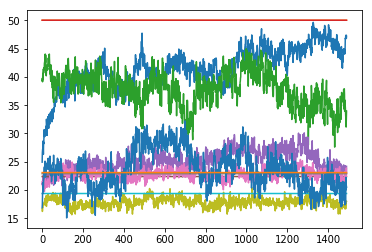

In [19]:
plt.plot(range(1491),predictions[0,:1491].numpy())
plt.plot(range(1491),np.linspace(y[0],y[0],1491))
plt.plot(range(1491),predictions[1,:1491].numpy())
plt.plot(range(1491),np.linspace(y[1],y[1],1491))
plt.plot(range(1491),predictions[2,:1491].numpy())
plt.plot(range(1491),np.linspace(y[2],y[2],1491))
plt.plot(range(1491),predictions[3,:1491].numpy())
plt.plot(range(1491),np.linspace(y[3],y[3],1491))
plt.plot(range(1491),predictions[4,:1491].numpy())
plt.plot(range(1491),np.linspace(y[4],y[4],1491))
plt.plot(range(1491),predictions[5,:1491].numpy())
plt.plot(range(1491),np.linspace(y[5],y[5],1491))

In [18]:
for x,y in iter(test_loader):
    x,y

(-8, 0)

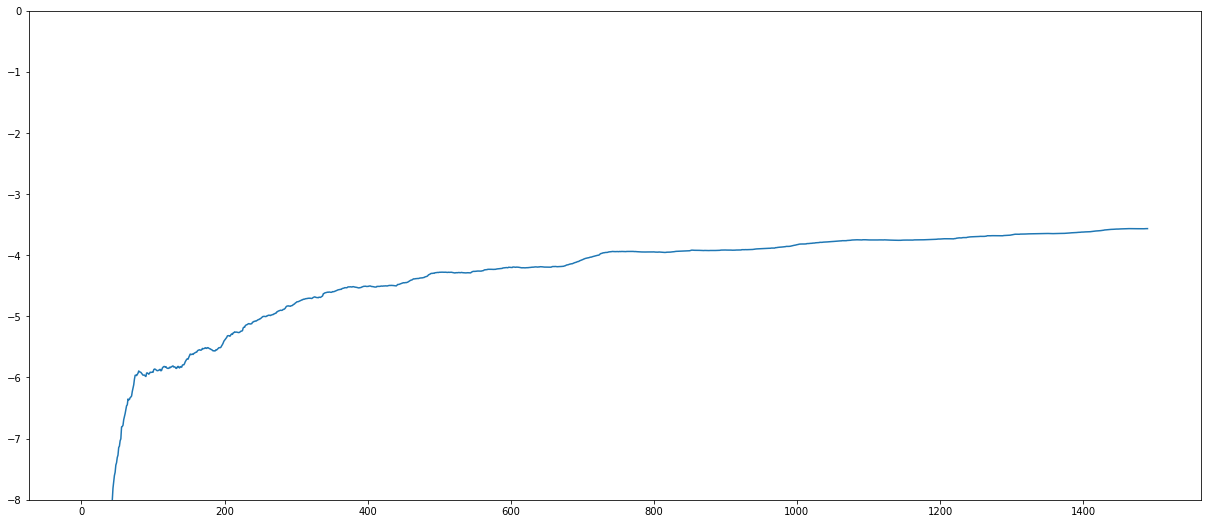

In [20]:
plt.figure(figsize=(21,9))
plt.plot(range(1491), log_lik_ksgfs)
plt.ylim(-8,0)

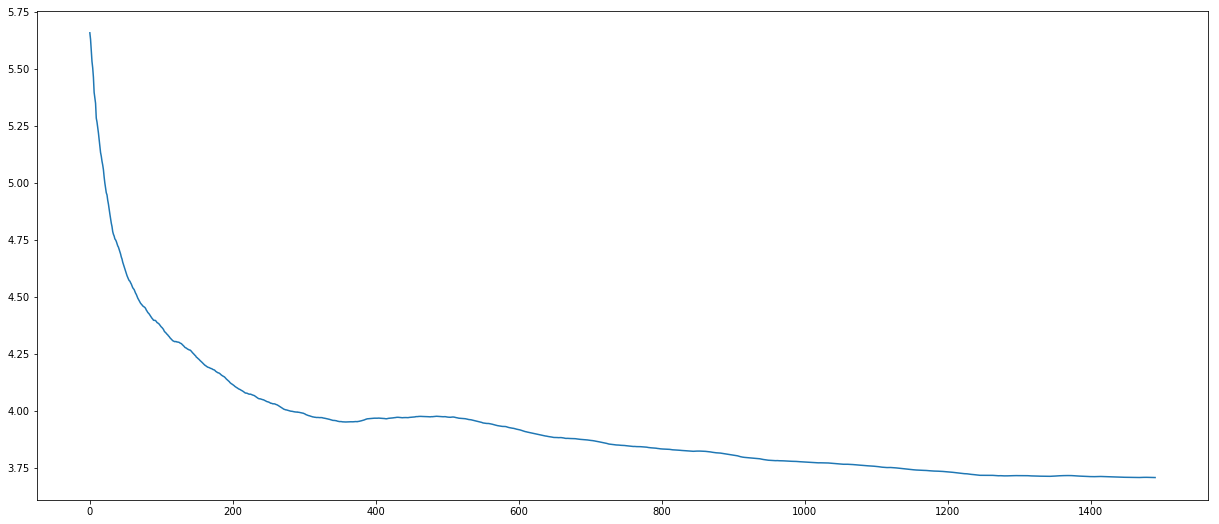

In [16]:
plt.figure(figsize=(21,9))
plt.plot(range(1491), test_rmse)

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
#from numpy.random import RandomState

import ksgld



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


batch_size = 32
dataset_size=456




network = Model()
criterion = nn.MSELoss(size_average=True)
#eps=5e-2

optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=5e-4, l2=1e-3, invert_every=1)
evaluate = evaluation(test_loader, 1., X_train_mean, X_train_std, y_train_mean, y_train_std)

losses_ksgld = []
log_lik_ksgld = []
test_rmse = []
t = 1.

for epoch in range(10000):
    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)

        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = 0.5 * criterion(output, y)
        loss.backward()
        optim.step()

        losses_ksgld.append(loss)
        running_loss += loss * batch_size / dataset_size

        if (t >= 1000) & (t % 100 == 0):
            with torch.autograd.no_grad():
#                 tau = 1.
#                 T = 50.
#                 rmse, log_lik = evaluate(network, test_loader, tau, T, y_train_mean, y_train_std)
                rmse, log_lik, predictions = evaluate.fn(network)
                test_rmse.append(rmse)
                log_lik_ksgld.append(log_lik)
        t += 1.


    print("Epoch {:d} - loss: {:.4f} ".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 0.4930 
Epoch 1 - loss: 0.4974 
Epoch 2 - loss: 0.4877 
Epoch 3 - loss: 0.4686 
Epoch 4 - loss: 0.4629 
Epoch 5 - loss: 0.4607 
Epoch 6 - loss: 0.4679 
Epoch 7 - loss: 0.4601 
Epoch 8 - loss: 0.4567 
Epoch 9 - loss: 0.4633 
Epoch 10 - loss: 0.4703 
Epoch 11 - loss: 0.4696 
Epoch 12 - loss: 0.4608 
Epoch 13 - loss: 0.4511 
Epoch 14 - loss: 0.4493 
Epoch 15 - loss: 0.4455 
Epoch 16 - loss: 0.4405 
Epoch 17 - loss: 0.4427 
Epoch 18 - loss: 0.4566 
Epoch 19 - loss: 0.4739 
Epoch 20 - loss: 0.4796 
Epoch 21 - loss: 0.4680 
Epoch 22 - loss: 0.4596 
Epoch 23 - loss: 0.4556 
Epoch 24 - loss: 0.4537 
Epoch 25 - loss: 0.4426 
Epoch 26 - loss: 0.4414 
Epoch 27 - loss: 0.4468 
Epoch 28 - loss: 0.4444 
Epoch 29 - loss: 0.4267 
Epoch 30 - loss: 0.4229 
Epoch 31 - loss: 0.4275 
Epoch 32 - loss: 0.4282 
Epoch 33 - loss: 0.4126 
Epoch 34 - loss: 0.4171 
Epoch 35 - loss: 0.4150 
Epoch 36 - loss: 0.4130 
Epoch 37 - loss: 0.4174 
Epoch 38 - loss: 0.4108 
Epoch 39 - loss: 0.4082 
Epoch 40 -

Epoch 320 - loss: 0.2996 
Epoch 321 - loss: 0.3045 
Epoch 322 - loss: 0.3083 
Epoch 323 - loss: 0.3069 
Epoch 324 - loss: 0.3099 
Epoch 325 - loss: 0.3061 
Epoch 326 - loss: 0.2987 
Epoch 327 - loss: 0.3058 
Epoch 328 - loss: 0.3207 
Epoch 329 - loss: 0.3180 
Epoch 330 - loss: 0.3178 
Epoch 331 - loss: 0.3301 
Epoch 332 - loss: 0.3410 
Epoch 333 - loss: 0.3415 
Epoch 334 - loss: 0.3385 
Epoch 335 - loss: 0.3332 
Epoch 336 - loss: 0.3369 
Epoch 337 - loss: 0.3249 
Epoch 338 - loss: 0.3321 
Epoch 339 - loss: 0.3340 
Epoch 340 - loss: 0.3315 
Epoch 341 - loss: 0.3123 
Epoch 342 - loss: 0.2939 
Epoch 343 - loss: 0.2986 
Epoch 344 - loss: 0.3026 
Epoch 345 - loss: 0.3196 
Epoch 346 - loss: 0.3337 
Epoch 347 - loss: 0.3467 
Epoch 348 - loss: 0.3425 
Epoch 349 - loss: 0.3286 
Epoch 350 - loss: 0.3229 
Epoch 351 - loss: 0.3246 
Epoch 352 - loss: 0.3223 
Epoch 353 - loss: 0.3240 
Epoch 354 - loss: 0.3163 
Epoch 355 - loss: 0.3032 
Epoch 356 - loss: 0.2988 
Epoch 357 - loss: 0.3121 
Epoch 358 - 

Epoch 636 - loss: 0.2431 
Epoch 637 - loss: 0.2564 
Epoch 638 - loss: 0.2662 
Epoch 639 - loss: 0.2761 
Epoch 640 - loss: 0.2954 
Epoch 641 - loss: 0.3079 
Epoch 642 - loss: 0.3150 
Epoch 643 - loss: 0.3084 
Epoch 644 - loss: 0.3264 
Epoch 645 - loss: 0.3441 
Epoch 646 - loss: 0.3387 
Epoch 647 - loss: 0.3347 
Epoch 648 - loss: 0.3310 
Epoch 649 - loss: 0.3228 
Epoch 650 - loss: 0.3201 
Epoch 651 - loss: 0.2991 
Epoch 652 - loss: 0.2996 
Epoch 653 - loss: 0.3043 
Epoch 654 - loss: 0.3028 
Epoch 655 - loss: 0.2964 
Epoch 656 - loss: 0.3038 
Epoch 657 - loss: 0.3020 
Epoch 658 - loss: 0.3280 
Epoch 659 - loss: 0.3518 
Epoch 660 - loss: 0.3490 
Epoch 661 - loss: 0.3385 
Epoch 662 - loss: 0.3418 
Epoch 663 - loss: 0.3338 
Epoch 664 - loss: 0.3053 
Epoch 665 - loss: 0.2697 
Epoch 666 - loss: 0.2471 
Epoch 667 - loss: 0.2615 
Epoch 668 - loss: 0.2776 
Epoch 669 - loss: 0.2666 
Epoch 670 - loss: 0.2716 
Epoch 671 - loss: 0.2981 
Epoch 672 - loss: 0.3008 
Epoch 673 - loss: 0.3345 
Epoch 674 - 

Epoch 952 - loss: 0.4486 
Epoch 953 - loss: 0.4544 
Epoch 954 - loss: 0.4397 
Epoch 955 - loss: 0.4833 
Epoch 956 - loss: 0.4721 
Epoch 957 - loss: 0.4692 
Epoch 958 - loss: 0.4760 
Epoch 959 - loss: 0.4554 
Epoch 960 - loss: 0.4129 
Epoch 961 - loss: 0.4157 
Epoch 962 - loss: 0.4203 
Epoch 963 - loss: 0.4525 
Epoch 964 - loss: 0.4339 
Epoch 965 - loss: 0.4393 
Epoch 966 - loss: 0.4244 
Epoch 967 - loss: 0.4236 
Epoch 968 - loss: 0.4360 
Epoch 969 - loss: 0.4619 
Epoch 970 - loss: 0.4915 
Epoch 971 - loss: 0.4894 
Epoch 972 - loss: 0.5075 
Epoch 973 - loss: 0.4852 
Epoch 974 - loss: 0.4856 
Epoch 975 - loss: 0.5212 
Epoch 976 - loss: 0.5763 
Epoch 977 - loss: 0.5610 
Epoch 978 - loss: 0.5338 
Epoch 979 - loss: 0.5130 
Epoch 980 - loss: 0.5227 
Epoch 981 - loss: 0.5059 
Epoch 982 - loss: 0.4850 
Epoch 983 - loss: 0.4949 
Epoch 984 - loss: 0.4877 
Epoch 985 - loss: 0.4800 
Epoch 986 - loss: 0.4636 
Epoch 987 - loss: 0.4541 
Epoch 988 - loss: 0.4493 
Epoch 989 - loss: 0.4139 
Epoch 990 - 

Epoch 1260 - loss: 0.2361 
Epoch 1261 - loss: 0.2559 
Epoch 1262 - loss: 0.2589 
Epoch 1263 - loss: 0.2652 
Epoch 1264 - loss: 0.2622 
Epoch 1265 - loss: 0.2747 
Epoch 1266 - loss: 0.3163 
Epoch 1267 - loss: 0.3066 
Epoch 1268 - loss: 0.3119 
Epoch 1269 - loss: 0.3525 
Epoch 1270 - loss: 0.3767 
Epoch 1271 - loss: 0.3674 
Epoch 1272 - loss: 0.3706 
Epoch 1273 - loss: 0.3797 
Epoch 1274 - loss: 0.3466 
Epoch 1275 - loss: 0.3471 
Epoch 1276 - loss: 0.3476 
Epoch 1277 - loss: 0.3276 
Epoch 1278 - loss: 0.3138 
Epoch 1279 - loss: 0.3088 
Epoch 1280 - loss: 0.2909 
Epoch 1281 - loss: 0.2637 
Epoch 1282 - loss: 0.2594 
Epoch 1283 - loss: 0.2671 
Epoch 1284 - loss: 0.2769 
Epoch 1285 - loss: 0.2829 
Epoch 1286 - loss: 0.2808 
Epoch 1287 - loss: 0.2825 
Epoch 1288 - loss: 0.2797 
Epoch 1289 - loss: 0.2570 
Epoch 1290 - loss: 0.2491 
Epoch 1291 - loss: 0.2489 
Epoch 1292 - loss: 0.2528 
Epoch 1293 - loss: 0.2510 
Epoch 1294 - loss: 0.2445 
Epoch 1295 - loss: 0.2339 
Epoch 1296 - loss: 0.2289 
E

Epoch 1566 - loss: 0.2926 
Epoch 1567 - loss: 0.3024 
Epoch 1568 - loss: 0.2987 
Epoch 1569 - loss: 0.2975 
Epoch 1570 - loss: 0.3288 
Epoch 1571 - loss: 0.3261 
Epoch 1572 - loss: 0.3382 
Epoch 1573 - loss: 0.3312 
Epoch 1574 - loss: 0.3165 
Epoch 1575 - loss: 0.3014 
Epoch 1576 - loss: 0.2845 
Epoch 1577 - loss: 0.2827 
Epoch 1578 - loss: 0.3034 
Epoch 1579 - loss: 0.3100 
Epoch 1580 - loss: 0.3139 
Epoch 1581 - loss: 0.2998 
Epoch 1582 - loss: 0.2846 
Epoch 1583 - loss: 0.2690 
Epoch 1584 - loss: 0.2707 
Epoch 1585 - loss: 0.2623 
Epoch 1586 - loss: 0.2627 
Epoch 1587 - loss: 0.2774 
Epoch 1588 - loss: 0.3247 
Epoch 1589 - loss: 0.3501 
Epoch 1590 - loss: 0.3891 
Epoch 1591 - loss: 0.3916 
Epoch 1592 - loss: 0.4055 
Epoch 1593 - loss: 0.3834 
Epoch 1594 - loss: 0.4005 
Epoch 1595 - loss: 0.4057 
Epoch 1596 - loss: 0.4290 
Epoch 1597 - loss: 0.4695 
Epoch 1598 - loss: 0.5405 
Epoch 1599 - loss: 0.6088 
Epoch 1600 - loss: 0.5929 
Epoch 1601 - loss: 0.6395 
Epoch 1602 - loss: 0.6826 
E

Epoch 1871 - loss: 0.2151 
Epoch 1872 - loss: 0.2095 
Epoch 1873 - loss: 0.2007 
Epoch 1874 - loss: 0.1967 
Epoch 1875 - loss: 0.1988 
Epoch 1876 - loss: 0.1977 
Epoch 1877 - loss: 0.2010 
Epoch 1878 - loss: 0.1981 
Epoch 1879 - loss: 0.1988 
Epoch 1880 - loss: 0.2052 
Epoch 1881 - loss: 0.2081 
Epoch 1882 - loss: 0.2084 
Epoch 1883 - loss: 0.2256 
Epoch 1884 - loss: 0.2431 
Epoch 1885 - loss: 0.2327 
Epoch 1886 - loss: 0.2280 
Epoch 1887 - loss: 0.2459 
Epoch 1888 - loss: 0.2679 
Epoch 1889 - loss: 0.2998 
Epoch 1890 - loss: 0.3334 
Epoch 1891 - loss: 0.3587 
Epoch 1892 - loss: 0.3609 
Epoch 1893 - loss: 0.3442 
Epoch 1894 - loss: 0.3157 
Epoch 1895 - loss: 0.2978 
Epoch 1896 - loss: 0.2875 
Epoch 1897 - loss: 0.2720 
Epoch 1898 - loss: 0.2594 
Epoch 1899 - loss: 0.2564 
Epoch 1900 - loss: 0.2519 
Epoch 1901 - loss: 0.2536 
Epoch 1902 - loss: 0.2513 
Epoch 1903 - loss: 0.2401 
Epoch 1904 - loss: 0.2416 
Epoch 1905 - loss: 0.2549 
Epoch 1906 - loss: 0.2494 
Epoch 1907 - loss: 0.2557 
E

Epoch 2176 - loss: 0.2304 
Epoch 2177 - loss: 0.2401 
Epoch 2178 - loss: 0.2457 
Epoch 2179 - loss: 0.2441 
Epoch 2180 - loss: 0.2356 
Epoch 2181 - loss: 0.2327 
Epoch 2182 - loss: 0.2380 
Epoch 2183 - loss: 0.2342 
Epoch 2184 - loss: 0.2237 
Epoch 2185 - loss: 0.2217 
Epoch 2186 - loss: 0.2175 
Epoch 2187 - loss: 0.2207 
Epoch 2188 - loss: 0.2246 
Epoch 2189 - loss: 0.2327 
Epoch 2190 - loss: 0.2305 
Epoch 2191 - loss: 0.2288 
Epoch 2192 - loss: 0.2235 
Epoch 2193 - loss: 0.2324 
Epoch 2194 - loss: 0.2335 
Epoch 2195 - loss: 0.2395 
Epoch 2196 - loss: 0.2350 
Epoch 2197 - loss: 0.2291 
Epoch 2198 - loss: 0.2230 
Epoch 2199 - loss: 0.2279 
Epoch 2200 - loss: 0.2347 
Epoch 2201 - loss: 0.2333 
Epoch 2202 - loss: 0.2445 
Epoch 2203 - loss: 0.2447 
Epoch 2204 - loss: 0.2482 
Epoch 2205 - loss: 0.2720 
Epoch 2206 - loss: 0.2833 
Epoch 2207 - loss: 0.2712 
Epoch 2208 - loss: 0.2814 
Epoch 2209 - loss: 0.2849 
Epoch 2210 - loss: 0.3177 
Epoch 2211 - loss: 0.3243 
Epoch 2212 - loss: 0.3048 
E

Epoch 2481 - loss: 0.1752 
Epoch 2482 - loss: 0.1770 
Epoch 2483 - loss: 0.1794 
Epoch 2484 - loss: 0.1793 
Epoch 2485 - loss: 0.1798 
Epoch 2486 - loss: 0.1771 
Epoch 2487 - loss: 0.1740 
Epoch 2488 - loss: 0.1749 
Epoch 2489 - loss: 0.1754 
Epoch 2490 - loss: 0.1763 
Epoch 2491 - loss: 0.1770 
Epoch 2492 - loss: 0.1759 
Epoch 2493 - loss: 0.1786 
Epoch 2494 - loss: 0.1796 
Epoch 2495 - loss: 0.1789 
Epoch 2496 - loss: 0.1804 
Epoch 2497 - loss: 0.1807 
Epoch 2498 - loss: 0.1778 
Epoch 2499 - loss: 0.1794 
Epoch 2500 - loss: 0.1803 
Epoch 2501 - loss: 0.1810 
Epoch 2502 - loss: 0.1808 
Epoch 2503 - loss: 0.1787 
Epoch 2504 - loss: 0.1816 
Epoch 2505 - loss: 0.1817 
Epoch 2506 - loss: 0.1800 
Epoch 2507 - loss: 0.1774 
Epoch 2508 - loss: 0.1778 
Epoch 2509 - loss: 0.1767 
Epoch 2510 - loss: 0.1767 
Epoch 2511 - loss: 0.1741 
Epoch 2512 - loss: 0.1772 
Epoch 2513 - loss: 0.1799 
Epoch 2514 - loss: 0.1826 
Epoch 2515 - loss: 0.1855 
Epoch 2516 - loss: 0.1851 
Epoch 2517 - loss: 0.1764 
E

Epoch 2787 - loss: 0.1698 
Epoch 2788 - loss: 0.1711 
Epoch 2789 - loss: 0.1687 
Epoch 2790 - loss: 0.1714 
Epoch 2791 - loss: 0.1714 
Epoch 2792 - loss: 0.1717 
Epoch 2793 - loss: 0.1734 
Epoch 2794 - loss: 0.1739 
Epoch 2795 - loss: 0.1731 
Epoch 2796 - loss: 0.1746 
Epoch 2797 - loss: 0.1771 
Epoch 2798 - loss: 0.1771 
Epoch 2799 - loss: 0.1758 
Epoch 2800 - loss: 0.1732 
Epoch 2801 - loss: 0.1702 
Epoch 2802 - loss: 0.1712 
Epoch 2803 - loss: 0.1712 
Epoch 2804 - loss: 0.1754 
Epoch 2805 - loss: 0.1788 
Epoch 2806 - loss: 0.1813 
Epoch 2807 - loss: 0.1802 
Epoch 2808 - loss: 0.1819 
Epoch 2809 - loss: 0.1785 
Epoch 2810 - loss: 0.1806 
Epoch 2811 - loss: 0.1855 
Epoch 2812 - loss: 0.1842 
Epoch 2813 - loss: 0.1856 
Epoch 2814 - loss: 0.1917 
Epoch 2815 - loss: 0.1926 
Epoch 2816 - loss: 0.1929 
Epoch 2817 - loss: 0.1919 
Epoch 2818 - loss: 0.1897 
Epoch 2819 - loss: 0.1886 
Epoch 2820 - loss: 0.1902 
Epoch 2821 - loss: 0.1878 
Epoch 2822 - loss: 0.2052 
Epoch 2823 - loss: 0.2235 
E

Epoch 3092 - loss: 0.1812 
Epoch 3093 - loss: 0.1817 
Epoch 3094 - loss: 0.1784 
Epoch 3095 - loss: 0.1815 
Epoch 3096 - loss: 0.1870 
Epoch 3097 - loss: 0.1941 
Epoch 3098 - loss: 0.1930 
Epoch 3099 - loss: 0.1905 
Epoch 3100 - loss: 0.1946 
Epoch 3101 - loss: 0.1997 
Epoch 3102 - loss: 0.1995 
Epoch 3103 - loss: 0.2008 
Epoch 3104 - loss: 0.2017 
Epoch 3105 - loss: 0.2097 
Epoch 3106 - loss: 0.1978 
Epoch 3107 - loss: 0.1884 
Epoch 3108 - loss: 0.1875 
Epoch 3109 - loss: 0.1895 
Epoch 3110 - loss: 0.1974 
Epoch 3111 - loss: 0.2030 
Epoch 3112 - loss: 0.2099 
Epoch 3113 - loss: 0.2186 
Epoch 3114 - loss: 0.2273 
Epoch 3115 - loss: 0.2206 
Epoch 3116 - loss: 0.2209 
Epoch 3117 - loss: 0.2161 
Epoch 3118 - loss: 0.2122 
Epoch 3119 - loss: 0.2156 
Epoch 3120 - loss: 0.2156 
Epoch 3121 - loss: 0.2114 
Epoch 3122 - loss: 0.2218 
Epoch 3123 - loss: 0.2283 
Epoch 3124 - loss: 0.2208 
Epoch 3125 - loss: 0.2210 
Epoch 3126 - loss: 0.2249 
Epoch 3127 - loss: 0.2164 
Epoch 3128 - loss: 0.2167 
E

Epoch 3397 - loss: 0.2889 
Epoch 3398 - loss: 0.2806 
Epoch 3399 - loss: 0.2927 
Epoch 3400 - loss: 0.3128 
Epoch 3401 - loss: 0.3336 
Epoch 3402 - loss: 0.3491 
Epoch 3403 - loss: 0.3488 
Epoch 3404 - loss: 0.3383 
Epoch 3405 - loss: 0.3435 
Epoch 3406 - loss: 0.3301 
Epoch 3407 - loss: 0.3163 
Epoch 3408 - loss: 0.3237 
Epoch 3409 - loss: 0.3255 
Epoch 3410 - loss: 0.3376 
Epoch 3411 - loss: 0.3495 
Epoch 3412 - loss: 0.3312 
Epoch 3413 - loss: 0.3219 
Epoch 3414 - loss: 0.3294 
Epoch 3415 - loss: 0.3456 
Epoch 3416 - loss: 0.3607 
Epoch 3417 - loss: 0.3760 
Epoch 3418 - loss: 0.3969 
Epoch 3419 - loss: 0.3932 
Epoch 3420 - loss: 0.4077 
Epoch 3421 - loss: 0.3933 
Epoch 3422 - loss: 0.3764 
Epoch 3423 - loss: 0.3828 
Epoch 3424 - loss: 0.3788 
Epoch 3425 - loss: 0.3429 
Epoch 3426 - loss: 0.3313 
Epoch 3427 - loss: 0.3310 
Epoch 3428 - loss: 0.3248 
Epoch 3429 - loss: 0.3416 
Epoch 3430 - loss: 0.3369 
Epoch 3431 - loss: 0.3421 
Epoch 3432 - loss: 0.3517 
Epoch 3433 - loss: 0.3605 
E

Epoch 3701 - loss: 0.5551 
Epoch 3702 - loss: 0.5366 
Epoch 3703 - loss: 0.5278 
Epoch 3704 - loss: 0.5590 
Epoch 3705 - loss: 0.5268 
Epoch 3706 - loss: 0.4869 
Epoch 3707 - loss: 0.4592 
Epoch 3708 - loss: 0.4391 
Epoch 3709 - loss: 0.4460 
Epoch 3710 - loss: 0.4232 
Epoch 3711 - loss: 0.4255 
Epoch 3712 - loss: 0.4678 
Epoch 3713 - loss: 0.5000 
Epoch 3714 - loss: 0.4935 
Epoch 3715 - loss: 0.5102 
Epoch 3716 - loss: 0.4951 
Epoch 3717 - loss: 0.4985 
Epoch 3718 - loss: 0.4593 
Epoch 3719 - loss: 0.4744 
Epoch 3720 - loss: 0.4837 
Epoch 3721 - loss: 0.4605 
Epoch 3722 - loss: 0.4781 
Epoch 3723 - loss: 0.5422 
Epoch 3724 - loss: 0.5248 
Epoch 3725 - loss: 0.4876 
Epoch 3726 - loss: 0.4564 
Epoch 3727 - loss: 0.4353 
Epoch 3728 - loss: 0.4428 
Epoch 3729 - loss: 0.4385 
Epoch 3730 - loss: 0.4629 
Epoch 3731 - loss: 0.4190 
Epoch 3732 - loss: 0.3774 
Epoch 3733 - loss: 0.3761 
Epoch 3734 - loss: 0.4028 
Epoch 3735 - loss: 0.4023 
Epoch 3736 - loss: 0.4282 
Epoch 3737 - loss: 0.4908 
E

Epoch 4006 - loss: 0.5738 
Epoch 4007 - loss: 0.5637 
Epoch 4008 - loss: 0.5334 
Epoch 4009 - loss: 0.5462 
Epoch 4010 - loss: 0.5761 
Epoch 4011 - loss: 0.5889 
Epoch 4012 - loss: 0.6440 
Epoch 4013 - loss: 0.6365 
Epoch 4014 - loss: 0.6680 
Epoch 4015 - loss: 0.6457 
Epoch 4016 - loss: 0.6558 
Epoch 4017 - loss: 0.6365 
Epoch 4018 - loss: 0.6387 
Epoch 4019 - loss: 0.6364 
Epoch 4020 - loss: 0.6165 
Epoch 4021 - loss: 0.5863 
Epoch 4022 - loss: 0.5786 
Epoch 4023 - loss: 0.5256 
Epoch 4024 - loss: 0.5417 
Epoch 4025 - loss: 0.5187 
Epoch 4026 - loss: 0.4793 
Epoch 4027 - loss: 0.4641 
Epoch 4028 - loss: 0.4439 
Epoch 4029 - loss: 0.4195 
Epoch 4030 - loss: 0.4074 
Epoch 4031 - loss: 0.4053 
Epoch 4032 - loss: 0.4099 
Epoch 4033 - loss: 0.4342 
Epoch 4034 - loss: 0.4499 
Epoch 4035 - loss: 0.4505 
Epoch 4036 - loss: 0.4277 
Epoch 4037 - loss: 0.4212 
Epoch 4038 - loss: 0.3931 
Epoch 4039 - loss: 0.3901 
Epoch 4040 - loss: 0.3878 
Epoch 4041 - loss: 0.4090 
Epoch 4042 - loss: 0.4534 
E

Epoch 4311 - loss: 0.3016 
Epoch 4312 - loss: 0.3076 
Epoch 4313 - loss: 0.3207 
Epoch 4314 - loss: 0.2977 
Epoch 4315 - loss: 0.2949 
Epoch 4316 - loss: 0.3112 
Epoch 4317 - loss: 0.3149 
Epoch 4318 - loss: 0.3358 
Epoch 4319 - loss: 0.3533 
Epoch 4320 - loss: 0.3592 
Epoch 4321 - loss: 0.3682 
Epoch 4322 - loss: 0.3746 
Epoch 4323 - loss: 0.3752 
Epoch 4324 - loss: 0.3901 
Epoch 4325 - loss: 0.3822 
Epoch 4326 - loss: 0.3678 
Epoch 4327 - loss: 0.3543 
Epoch 4328 - loss: 0.3451 
Epoch 4329 - loss: 0.3254 
Epoch 4330 - loss: 0.3139 
Epoch 4331 - loss: 0.3052 
Epoch 4332 - loss: 0.2937 
Epoch 4333 - loss: 0.2913 
Epoch 4334 - loss: 0.2679 
Epoch 4335 - loss: 0.2638 
Epoch 4336 - loss: 0.2657 
Epoch 4337 - loss: 0.2785 
Epoch 4338 - loss: 0.2693 
Epoch 4339 - loss: 0.2744 
Epoch 4340 - loss: 0.2618 
Epoch 4341 - loss: 0.2627 
Epoch 4342 - loss: 0.2575 
Epoch 4343 - loss: 0.2715 
Epoch 4344 - loss: 0.2870 
Epoch 4345 - loss: 0.2869 
Epoch 4346 - loss: 0.2739 
Epoch 4347 - loss: 0.2802 
E

Epoch 4616 - loss: 0.2251 
Epoch 4617 - loss: 0.2310 
Epoch 4618 - loss: 0.2304 
Epoch 4619 - loss: 0.2294 
Epoch 4620 - loss: 0.2346 
Epoch 4621 - loss: 0.2395 
Epoch 4622 - loss: 0.2335 
Epoch 4623 - loss: 0.2334 
Epoch 4624 - loss: 0.2362 
Epoch 4625 - loss: 0.2368 
Epoch 4626 - loss: 0.2398 
Epoch 4627 - loss: 0.2350 
Epoch 4628 - loss: 0.2400 
Epoch 4629 - loss: 0.2456 
Epoch 4630 - loss: 0.2524 
Epoch 4631 - loss: 0.2491 
Epoch 4632 - loss: 0.2486 
Epoch 4633 - loss: 0.2496 
Epoch 4634 - loss: 0.2348 
Epoch 4635 - loss: 0.2303 
Epoch 4636 - loss: 0.2349 
Epoch 4637 - loss: 0.2400 
Epoch 4638 - loss: 0.2349 
Epoch 4639 - loss: 0.2323 
Epoch 4640 - loss: 0.2339 
Epoch 4641 - loss: 0.2258 
Epoch 4642 - loss: 0.2215 
Epoch 4643 - loss: 0.2263 
Epoch 4644 - loss: 0.2214 
Epoch 4645 - loss: 0.2186 
Epoch 4646 - loss: 0.2296 
Epoch 4647 - loss: 0.2333 
Epoch 4648 - loss: 0.2309 
Epoch 4649 - loss: 0.2312 
Epoch 4650 - loss: 0.2243 
Epoch 4651 - loss: 0.2250 
Epoch 4652 - loss: 0.2309 
E

Epoch 4921 - loss: 0.5320 
Epoch 4922 - loss: 0.5223 
Epoch 4923 - loss: 0.5004 
Epoch 4924 - loss: 0.4640 
Epoch 4925 - loss: 0.4950 
Epoch 4926 - loss: 0.4958 
Epoch 4927 - loss: 0.5117 
Epoch 4928 - loss: 0.5065 
Epoch 4929 - loss: 0.5118 
Epoch 4930 - loss: 0.4696 
Epoch 4931 - loss: 0.4224 
Epoch 4932 - loss: 0.4159 
Epoch 4933 - loss: 0.4302 
Epoch 4934 - loss: 0.4377 
Epoch 4935 - loss: 0.4432 
Epoch 4936 - loss: 0.4137 
Epoch 4937 - loss: 0.4017 
Epoch 4938 - loss: 0.4018 
Epoch 4939 - loss: 0.4031 
Epoch 4940 - loss: 0.3846 
Epoch 4941 - loss: 0.3859 
Epoch 4942 - loss: 0.3648 
Epoch 4943 - loss: 0.4022 
Epoch 4944 - loss: 0.4349 
Epoch 4945 - loss: 0.4449 
Epoch 4946 - loss: 0.4479 
Epoch 4947 - loss: 0.4211 
Epoch 4948 - loss: 0.4132 
Epoch 4949 - loss: 0.3983 
Epoch 4950 - loss: 0.3622 
Epoch 4951 - loss: 0.3453 
Epoch 4952 - loss: 0.3491 
Epoch 4953 - loss: 0.3472 
Epoch 4954 - loss: 0.3669 
Epoch 4955 - loss: 0.3865 
Epoch 4956 - loss: 0.4046 
Epoch 4957 - loss: 0.4205 
E

Epoch 5225 - loss: 0.3854 
Epoch 5226 - loss: 0.4239 
Epoch 5227 - loss: 0.4309 
Epoch 5228 - loss: 0.4251 
Epoch 5229 - loss: 0.3688 
Epoch 5230 - loss: 0.3592 
Epoch 5231 - loss: 0.3504 
Epoch 5232 - loss: 0.3076 
Epoch 5233 - loss: 0.3033 
Epoch 5234 - loss: 0.2882 
Epoch 5235 - loss: 0.2787 
Epoch 5236 - loss: 0.3093 
Epoch 5237 - loss: 0.3067 
Epoch 5238 - loss: 0.2952 
Epoch 5239 - loss: 0.2792 
Epoch 5240 - loss: 0.2673 
Epoch 5241 - loss: 0.2420 
Epoch 5242 - loss: 0.2445 
Epoch 5243 - loss: 0.2559 
Epoch 5244 - loss: 0.2429 
Epoch 5245 - loss: 0.2469 
Epoch 5246 - loss: 0.2542 
Epoch 5247 - loss: 0.2457 
Epoch 5248 - loss: 0.2560 
Epoch 5249 - loss: 0.2717 
Epoch 5250 - loss: 0.3013 
Epoch 5251 - loss: 0.2982 
Epoch 5252 - loss: 0.2922 
Epoch 5253 - loss: 0.2765 
Epoch 5254 - loss: 0.2619 
Epoch 5255 - loss: 0.2620 
Epoch 5256 - loss: 0.2585 
Epoch 5257 - loss: 0.2470 
Epoch 5258 - loss: 0.2473 
Epoch 5259 - loss: 0.2509 
Epoch 5260 - loss: 0.2230 
Epoch 5261 - loss: 0.2080 
E

Epoch 5530 - loss: 0.2819 
Epoch 5531 - loss: 0.2952 
Epoch 5532 - loss: 0.3054 
Epoch 5533 - loss: 0.3089 
Epoch 5534 - loss: 0.2966 
Epoch 5535 - loss: 0.2879 
Epoch 5536 - loss: 0.2856 
Epoch 5537 - loss: 0.2759 
Epoch 5538 - loss: 0.2740 
Epoch 5539 - loss: 0.2756 
Epoch 5540 - loss: 0.3014 
Epoch 5541 - loss: 0.3048 
Epoch 5542 - loss: 0.3029 
Epoch 5543 - loss: 0.3060 
Epoch 5544 - loss: 0.3007 
Epoch 5545 - loss: 0.2864 
Epoch 5546 - loss: 0.2724 
Epoch 5547 - loss: 0.2735 
Epoch 5548 - loss: 0.2570 
Epoch 5549 - loss: 0.2691 
Epoch 5550 - loss: 0.2932 
Epoch 5551 - loss: 0.2941 
Epoch 5552 - loss: 0.2950 
Epoch 5553 - loss: 0.2933 
Epoch 5554 - loss: 0.2852 
Epoch 5555 - loss: 0.3017 
Epoch 5556 - loss: 0.3035 
Epoch 5557 - loss: 0.3257 
Epoch 5558 - loss: 0.3347 
Epoch 5559 - loss: 0.3168 
Epoch 5560 - loss: 0.2972 
Epoch 5561 - loss: 0.2927 
Epoch 5562 - loss: 0.2966 
Epoch 5563 - loss: 0.2915 
Epoch 5564 - loss: 0.2887 
Epoch 5565 - loss: 0.3075 
Epoch 5566 - loss: 0.3213 
E

Epoch 5836 - loss: 0.2237 
Epoch 5837 - loss: 0.2179 
Epoch 5838 - loss: 0.2157 
Epoch 5839 - loss: 0.2099 
Epoch 5840 - loss: 0.1988 
Epoch 5841 - loss: 0.1908 
Epoch 5842 - loss: 0.1919 
Epoch 5843 - loss: 0.1963 
Epoch 5844 - loss: 0.1941 
Epoch 5845 - loss: 0.1960 
Epoch 5846 - loss: 0.2052 
Epoch 5847 - loss: 0.2000 
Epoch 5848 - loss: 0.1928 
Epoch 5849 - loss: 0.1883 
Epoch 5850 - loss: 0.1912 
Epoch 5851 - loss: 0.1885 
Epoch 5852 - loss: 0.1916 
Epoch 5853 - loss: 0.1851 
Epoch 5854 - loss: 0.1832 
Epoch 5855 - loss: 0.1891 
Epoch 5856 - loss: 0.1880 
Epoch 5857 - loss: 0.1894 
Epoch 5858 - loss: 0.1822 
Epoch 5859 - loss: 0.1790 
Epoch 5860 - loss: 0.1781 
Epoch 5861 - loss: 0.1840 
Epoch 5862 - loss: 0.1796 
Epoch 5863 - loss: 0.1784 
Epoch 5864 - loss: 0.1842 
Epoch 5865 - loss: 0.1814 
Epoch 5866 - loss: 0.1742 
Epoch 5867 - loss: 0.1712 
Epoch 5868 - loss: 0.1725 
Epoch 5869 - loss: 0.1736 
Epoch 5870 - loss: 0.1763 
Epoch 5871 - loss: 0.1756 
Epoch 5872 - loss: 0.1765 
E

Epoch 6141 - loss: 0.1494 
Epoch 6142 - loss: 0.1473 
Epoch 6143 - loss: 0.1484 
Epoch 6144 - loss: 0.1489 
Epoch 6145 - loss: 0.1474 
Epoch 6146 - loss: 0.1478 
Epoch 6147 - loss: 0.1487 
Epoch 6148 - loss: 0.1516 
Epoch 6149 - loss: 0.1521 
Epoch 6150 - loss: 0.1494 
Epoch 6151 - loss: 0.1496 
Epoch 6152 - loss: 0.1487 
Epoch 6153 - loss: 0.1481 
Epoch 6154 - loss: 0.1474 
Epoch 6155 - loss: 0.1480 
Epoch 6156 - loss: 0.1479 
Epoch 6157 - loss: 0.1476 
Epoch 6158 - loss: 0.1474 
Epoch 6159 - loss: 0.1498 
Epoch 6160 - loss: 0.1516 
Epoch 6161 - loss: 0.1526 
Epoch 6162 - loss: 0.1564 
Epoch 6163 - loss: 0.1569 
Epoch 6164 - loss: 0.1611 
Epoch 6165 - loss: 0.1588 
Epoch 6166 - loss: 0.1604 
Epoch 6167 - loss: 0.1630 
Epoch 6168 - loss: 0.1623 
Epoch 6169 - loss: 0.1682 
Epoch 6170 - loss: 0.1645 
Epoch 6171 - loss: 0.1657 
Epoch 6172 - loss: 0.1603 
Epoch 6173 - loss: 0.1649 
Epoch 6174 - loss: 0.1711 
Epoch 6175 - loss: 0.1712 
Epoch 6176 - loss: 0.1731 
Epoch 6177 - loss: 0.1658 
E

Epoch 6445 - loss: 0.1983 
Epoch 6446 - loss: 0.1963 
Epoch 6447 - loss: 0.2109 
Epoch 6448 - loss: 0.2207 
Epoch 6449 - loss: 0.2130 
Epoch 6450 - loss: 0.1941 
Epoch 6451 - loss: 0.1934 
Epoch 6452 - loss: 0.1917 
Epoch 6453 - loss: 0.2012 
Epoch 6454 - loss: 0.2022 
Epoch 6455 - loss: 0.2099 
Epoch 6456 - loss: 0.2033 
Epoch 6457 - loss: 0.2002 
Epoch 6458 - loss: 0.2047 
Epoch 6459 - loss: 0.2060 
Epoch 6460 - loss: 0.2009 
Epoch 6461 - loss: 0.1980 
Epoch 6462 - loss: 0.1998 
Epoch 6463 - loss: 0.1969 
Epoch 6464 - loss: 0.1928 
Epoch 6465 - loss: 0.1976 
Epoch 6466 - loss: 0.2060 
Epoch 6467 - loss: 0.1980 
Epoch 6468 - loss: 0.1923 
Epoch 6469 - loss: 0.2105 
Epoch 6470 - loss: 0.2221 
Epoch 6471 - loss: 0.2238 
Epoch 6472 - loss: 0.2287 
Epoch 6473 - loss: 0.2160 
Epoch 6474 - loss: 0.2079 
Epoch 6475 - loss: 0.2111 
Epoch 6476 - loss: 0.2151 
Epoch 6477 - loss: 0.2128 
Epoch 6478 - loss: 0.2141 
Epoch 6479 - loss: 0.2093 
Epoch 6480 - loss: 0.2037 
Epoch 6481 - loss: 0.2025 
E

Epoch 6750 - loss: 0.2304 
Epoch 6751 - loss: 0.2377 
Epoch 6752 - loss: 0.2341 
Epoch 6753 - loss: 0.2310 
Epoch 6754 - loss: 0.2326 
Epoch 6755 - loss: 0.2345 
Epoch 6756 - loss: 0.2307 
Epoch 6757 - loss: 0.2211 
Epoch 6758 - loss: 0.2142 
Epoch 6759 - loss: 0.2268 
Epoch 6760 - loss: 0.2453 
Epoch 6761 - loss: 0.2483 
Epoch 6762 - loss: 0.2522 
Epoch 6763 - loss: 0.2473 
Epoch 6764 - loss: 0.2516 
Epoch 6765 - loss: 0.2587 
Epoch 6766 - loss: 0.2632 
Epoch 6767 - loss: 0.2515 
Epoch 6768 - loss: 0.2519 
Epoch 6769 - loss: 0.2396 
Epoch 6770 - loss: 0.2368 
Epoch 6771 - loss: 0.2365 
Epoch 6772 - loss: 0.2328 
Epoch 6773 - loss: 0.2402 
Epoch 6774 - loss: 0.2370 
Epoch 6775 - loss: 0.2370 
Epoch 6776 - loss: 0.2396 
Epoch 6777 - loss: 0.2423 
Epoch 6778 - loss: 0.2502 
Epoch 6779 - loss: 0.2494 
Epoch 6780 - loss: 0.2409 
Epoch 6781 - loss: 0.2384 
Epoch 6782 - loss: 0.2294 
Epoch 6783 - loss: 0.2255 
Epoch 6784 - loss: 0.2242 
Epoch 6785 - loss: 0.2332 
Epoch 6786 - loss: 0.2344 
E

Epoch 7055 - loss: 0.5017 
Epoch 7056 - loss: 0.5002 
Epoch 7057 - loss: 0.4841 
Epoch 7058 - loss: 0.4662 
Epoch 7059 - loss: 0.4932 
Epoch 7060 - loss: 0.4957 
Epoch 7061 - loss: 0.5259 
Epoch 7062 - loss: 0.5186 
Epoch 7063 - loss: 0.5067 
Epoch 7064 - loss: 0.5092 
Epoch 7065 - loss: 0.5197 
Epoch 7066 - loss: 0.5368 
Epoch 7067 - loss: 0.5766 
Epoch 7068 - loss: 0.5727 
Epoch 7069 - loss: 0.5592 
Epoch 7070 - loss: 0.5590 
Epoch 7071 - loss: 0.5720 
Epoch 7072 - loss: 0.5618 
Epoch 7073 - loss: 0.5330 
Epoch 7074 - loss: 0.4777 
Epoch 7075 - loss: 0.4699 
Epoch 7076 - loss: 0.4751 
Epoch 7077 - loss: 0.4803 
Epoch 7078 - loss: 0.5340 
Epoch 7079 - loss: 0.5607 
Epoch 7080 - loss: 0.5410 
Epoch 7081 - loss: 0.5294 
Epoch 7082 - loss: 0.5094 
Epoch 7083 - loss: 0.5167 
Epoch 7084 - loss: 0.5549 
Epoch 7085 - loss: 0.5673 
Epoch 7086 - loss: 0.5688 
Epoch 7087 - loss: 0.5743 
Epoch 7088 - loss: 0.5749 
Epoch 7089 - loss: 0.5637 
Epoch 7090 - loss: 0.5739 
Epoch 7091 - loss: 0.6065 
E

Epoch 7359 - loss: 0.2745 
Epoch 7360 - loss: 0.2760 
Epoch 7361 - loss: 0.2748 
Epoch 7362 - loss: 0.2763 
Epoch 7363 - loss: 0.2767 
Epoch 7364 - loss: 0.2686 
Epoch 7365 - loss: 0.2646 
Epoch 7366 - loss: 0.2631 
Epoch 7367 - loss: 0.2635 
Epoch 7368 - loss: 0.2622 
Epoch 7369 - loss: 0.2764 
Epoch 7370 - loss: 0.2854 
Epoch 7371 - loss: 0.2790 
Epoch 7372 - loss: 0.2681 
Epoch 7373 - loss: 0.2691 
Epoch 7374 - loss: 0.2683 
Epoch 7375 - loss: 0.2590 
Epoch 7376 - loss: 0.2593 
Epoch 7377 - loss: 0.2680 
Epoch 7378 - loss: 0.2741 
Epoch 7379 - loss: 0.2896 
Epoch 7380 - loss: 0.2848 
Epoch 7381 - loss: 0.2932 
Epoch 7382 - loss: 0.2920 
Epoch 7383 - loss: 0.2968 
Epoch 7384 - loss: 0.2882 
Epoch 7385 - loss: 0.2880 
Epoch 7386 - loss: 0.2863 
Epoch 7387 - loss: 0.2905 
Epoch 7388 - loss: 0.2863 
Epoch 7389 - loss: 0.2763 
Epoch 7390 - loss: 0.2754 
Epoch 7391 - loss: 0.2857 
Epoch 7392 - loss: 0.2936 
Epoch 7393 - loss: 0.2883 
Epoch 7394 - loss: 0.2916 
Epoch 7395 - loss: 0.3084 
E

Epoch 7663 - loss: 1.2889 
Epoch 7664 - loss: 1.3500 
Epoch 7665 - loss: 1.3130 
Epoch 7666 - loss: 1.4208 
Epoch 7667 - loss: 1.3722 
Epoch 7668 - loss: 1.2818 
Epoch 7669 - loss: 1.1728 
Epoch 7670 - loss: 1.1601 
Epoch 7671 - loss: 1.2146 
Epoch 7672 - loss: 1.2590 
Epoch 7673 - loss: 1.3176 
Epoch 7674 - loss: 1.4207 
Epoch 7675 - loss: 1.4059 
Epoch 7676 - loss: 1.3567 
Epoch 7677 - loss: 1.3049 
Epoch 7678 - loss: 1.2424 
Epoch 7679 - loss: 1.2723 
Epoch 7680 - loss: 1.2520 
Epoch 7681 - loss: 1.1631 
Epoch 7682 - loss: 1.2066 
Epoch 7683 - loss: 1.2437 
Epoch 7684 - loss: 1.2208 
Epoch 7685 - loss: 1.2609 
Epoch 7686 - loss: 1.2629 
Epoch 7687 - loss: 1.2795 
Epoch 7688 - loss: 1.2737 
Epoch 7689 - loss: 1.2826 
Epoch 7690 - loss: 1.2478 
Epoch 7691 - loss: 1.1577 
Epoch 7692 - loss: 1.1949 
Epoch 7693 - loss: 1.1308 
Epoch 7694 - loss: 1.0655 
Epoch 7695 - loss: 1.0136 
Epoch 7696 - loss: 0.9868 
Epoch 7697 - loss: 0.9688 
Epoch 7698 - loss: 1.0071 
Epoch 7699 - loss: 1.0978 
E

Epoch 7968 - loss: 0.3368 
Epoch 7969 - loss: 0.3438 
Epoch 7970 - loss: 0.3244 
Epoch 7971 - loss: 0.3197 
Epoch 7972 - loss: 0.3217 
Epoch 7973 - loss: 0.3300 
Epoch 7974 - loss: 0.3448 
Epoch 7975 - loss: 0.3524 
Epoch 7976 - loss: 0.3474 
Epoch 7977 - loss: 0.3537 
Epoch 7978 - loss: 0.3715 
Epoch 7979 - loss: 0.3924 
Epoch 7980 - loss: 0.3794 
Epoch 7981 - loss: 0.3701 
Epoch 7982 - loss: 0.3468 
Epoch 7983 - loss: 0.3447 
Epoch 7984 - loss: 0.3435 
Epoch 7985 - loss: 0.3493 
Epoch 7986 - loss: 0.3592 
Epoch 7987 - loss: 0.3779 
Epoch 7988 - loss: 0.3967 
Epoch 7989 - loss: 0.4074 
Epoch 7990 - loss: 0.3845 
Epoch 7991 - loss: 0.3544 
Epoch 7992 - loss: 0.3577 
Epoch 7993 - loss: 0.3650 
Epoch 7994 - loss: 0.3696 
Epoch 7995 - loss: 0.3667 
Epoch 7996 - loss: 0.3498 
Epoch 7997 - loss: 0.3302 
Epoch 7998 - loss: 0.3265 
Epoch 7999 - loss: 0.3143 
Epoch 8000 - loss: 0.3354 
Epoch 8001 - loss: 0.3476 
Epoch 8002 - loss: 0.3579 
Epoch 8003 - loss: 0.3537 
Epoch 8004 - loss: 0.3599 
E

Epoch 8273 - loss: 0.3073 
Epoch 8274 - loss: 0.2973 
Epoch 8275 - loss: 0.2865 
Epoch 8276 - loss: 0.2820 
Epoch 8277 - loss: 0.2906 
Epoch 8278 - loss: 0.2855 
Epoch 8279 - loss: 0.2899 
Epoch 8280 - loss: 0.2829 
Epoch 8281 - loss: 0.2895 
Epoch 8282 - loss: 0.2932 
Epoch 8283 - loss: 0.3018 
Epoch 8284 - loss: 0.3144 
Epoch 8285 - loss: 0.3153 
Epoch 8286 - loss: 0.3040 
Epoch 8287 - loss: 0.2849 
Epoch 8288 - loss: 0.2836 
Epoch 8289 - loss: 0.3027 
Epoch 8290 - loss: 0.3074 
Epoch 8291 - loss: 0.3138 
Epoch 8292 - loss: 0.3248 
Epoch 8293 - loss: 0.3210 
Epoch 8294 - loss: 0.2987 
Epoch 8295 - loss: 0.3034 
Epoch 8296 - loss: 0.2997 
Epoch 8297 - loss: 0.3031 
Epoch 8298 - loss: 0.3150 
Epoch 8299 - loss: 0.3229 
Epoch 8300 - loss: 0.3210 
Epoch 8301 - loss: 0.3120 
Epoch 8302 - loss: 0.2971 
Epoch 8303 - loss: 0.2907 
Epoch 8304 - loss: 0.2978 
Epoch 8305 - loss: 0.3035 
Epoch 8306 - loss: 0.3090 
Epoch 8307 - loss: 0.3463 
Epoch 8308 - loss: 0.3602 
Epoch 8309 - loss: 0.3626 
E

Epoch 8579 - loss: 0.2498 
Epoch 8580 - loss: 0.2515 
Epoch 8581 - loss: 0.2549 
Epoch 8582 - loss: 0.2607 
Epoch 8583 - loss: 0.2604 
Epoch 8584 - loss: 0.2658 
Epoch 8585 - loss: 0.2709 
Epoch 8586 - loss: 0.2734 
Epoch 8587 - loss: 0.2836 
Epoch 8588 - loss: 0.2836 
Epoch 8589 - loss: 0.2813 
Epoch 8590 - loss: 0.2775 
Epoch 8591 - loss: 0.2759 
Epoch 8592 - loss: 0.2791 
Epoch 8593 - loss: 0.2678 
Epoch 8594 - loss: 0.2682 
Epoch 8595 - loss: 0.2690 
Epoch 8596 - loss: 0.2605 
Epoch 8597 - loss: 0.2655 
Epoch 8598 - loss: 0.2621 
Epoch 8599 - loss: 0.2536 
Epoch 8600 - loss: 0.2536 
Epoch 8601 - loss: 0.2487 
Epoch 8602 - loss: 0.2429 
Epoch 8603 - loss: 0.2472 
Epoch 8604 - loss: 0.2544 
Epoch 8605 - loss: 0.2531 
Epoch 8606 - loss: 0.2494 
Epoch 8607 - loss: 0.2512 
Epoch 8608 - loss: 0.2546 
Epoch 8609 - loss: 0.2569 
Epoch 8610 - loss: 0.2654 
Epoch 8611 - loss: 0.2689 
Epoch 8612 - loss: 0.2694 
Epoch 8613 - loss: 0.2775 
Epoch 8614 - loss: 0.2752 
Epoch 8615 - loss: 0.2684 
E

Epoch 8883 - loss: 0.3417 
Epoch 8884 - loss: 0.3388 
Epoch 8885 - loss: 0.3070 
Epoch 8886 - loss: 0.2959 
Epoch 8887 - loss: 0.2855 
Epoch 8888 - loss: 0.2658 
Epoch 8889 - loss: 0.2647 
Epoch 8890 - loss: 0.2662 
Epoch 8891 - loss: 0.2754 
Epoch 8892 - loss: 0.2764 
Epoch 8893 - loss: 0.2677 
Epoch 8894 - loss: 0.2623 
Epoch 8895 - loss: 0.2603 
Epoch 8896 - loss: 0.2554 
Epoch 8897 - loss: 0.2541 
Epoch 8898 - loss: 0.2584 
Epoch 8899 - loss: 0.2588 
Epoch 8900 - loss: 0.2604 
Epoch 8901 - loss: 0.2465 
Epoch 8902 - loss: 0.2443 
Epoch 8903 - loss: 0.2447 
Epoch 8904 - loss: 0.2523 
Epoch 8905 - loss: 0.2505 
Epoch 8906 - loss: 0.2462 
Epoch 8907 - loss: 0.2426 
Epoch 8908 - loss: 0.2429 
Epoch 8909 - loss: 0.2372 
Epoch 8910 - loss: 0.2346 
Epoch 8911 - loss: 0.2367 
Epoch 8912 - loss: 0.2356 
Epoch 8913 - loss: 0.2348 
Epoch 8914 - loss: 0.2376 
Epoch 8915 - loss: 0.2441 
Epoch 8916 - loss: 0.2380 
Epoch 8917 - loss: 0.2332 
Epoch 8918 - loss: 0.2311 
Epoch 8919 - loss: 0.2349 
E

Epoch 9187 - loss: 0.3217 
Epoch 9188 - loss: 0.3223 
Epoch 9189 - loss: 0.3202 
Epoch 9190 - loss: 0.3078 
Epoch 9191 - loss: 0.3129 
Epoch 9192 - loss: 0.3176 
Epoch 9193 - loss: 0.3239 
Epoch 9194 - loss: 0.3297 
Epoch 9195 - loss: 0.3148 
Epoch 9196 - loss: 0.3167 
Epoch 9197 - loss: 0.3198 
Epoch 9198 - loss: 0.3307 
Epoch 9199 - loss: 0.3460 
Epoch 9200 - loss: 0.3480 
Epoch 9201 - loss: 0.3349 
Epoch 9202 - loss: 0.3255 
Epoch 9203 - loss: 0.3121 
Epoch 9204 - loss: 0.2976 
Epoch 9205 - loss: 0.2958 
Epoch 9206 - loss: 0.2929 
Epoch 9207 - loss: 0.2818 
Epoch 9208 - loss: 0.2726 
Epoch 9209 - loss: 0.2687 
Epoch 9210 - loss: 0.2746 
Epoch 9211 - loss: 0.2769 
Epoch 9212 - loss: 0.2854 
Epoch 9213 - loss: 0.2821 
Epoch 9214 - loss: 0.2866 
Epoch 9215 - loss: 0.2900 
Epoch 9216 - loss: 0.2873 
Epoch 9217 - loss: 0.2824 
Epoch 9218 - loss: 0.2781 
Epoch 9219 - loss: 0.2751 
Epoch 9220 - loss: 0.2718 
Epoch 9221 - loss: 0.2675 
Epoch 9222 - loss: 0.2639 
Epoch 9223 - loss: 0.2633 
E

In [13]:
log_lik_ksgld[-1]

tensor(-3.1277)

(-10, 0)

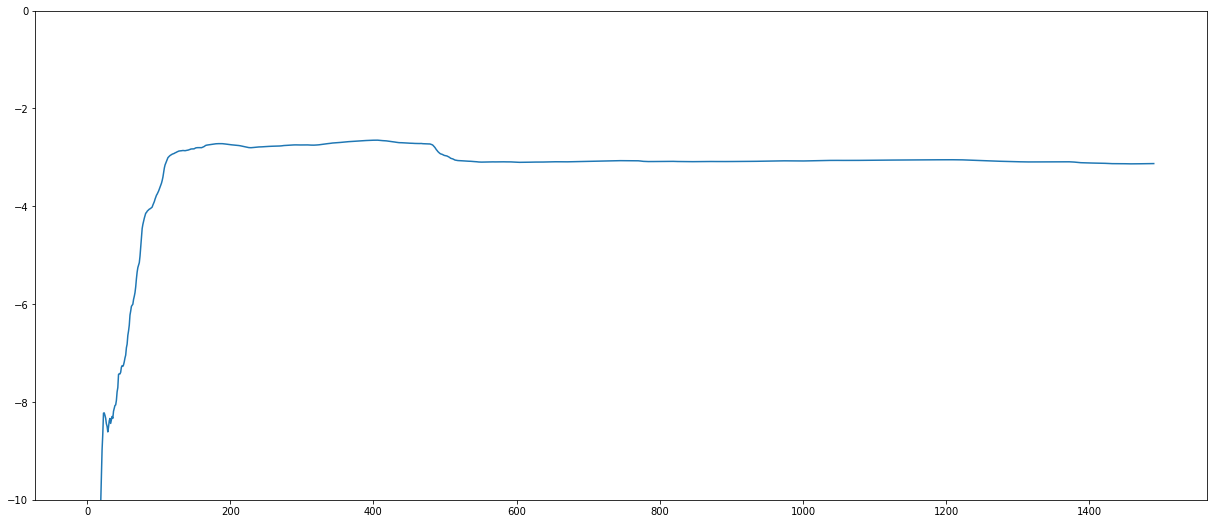

In [15]:
plt.figure(figsize=(21,9))
plt.plot(range(1491),log_lik_ksgld)
plt.ylim(-10,0)

In [ ]:
log_lik_ksgld[-1]

In [ ]:
plt.figure(figsize=(21,9))
plt.plot(range(2901),test_rmse)
plt.plot()

# Simulated Datasets

## Cubic

20 data points simulated as follows:

- x sampled from $\mathcal{U}(-4,4)$
- y sampled from $\mathcal{N}(x^3,3^2)$

In [ ]:
x, _ = torch.empty(20,1).uniform_(-4,4).sort(0)
y = torch.normal(x**3,3)
grid = np.linspace(-6,6,400).reshape(-1,1)
y_true = grid ** 3

In [ ]:
plt.plot(x.numpy(),y.numpy(),'o')
plt.plot(grid,y_true)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(1, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgd

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1.
lr = 1e-4


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=False)

optim = sgd.optim.sgd(network, lr, lambda_, dataset_size)


#test_rmse = []
#log_lik_sgld = []


x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(20000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = criterion(output, y)
    loss.backward()
    optim.step()




    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    
with torch.autograd.no_grad():
    prediction_sgd = network(x_test)

In [ ]:
plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(prediction_sgd.detach().numpy(),1),'black')
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')



### SGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1e-3
lr = 1e-3


batch_size = 20
dataset_size = 20

network = Model()
criterion = nn.MSELoss(size_average=True)

# optim = sgld.optim.sgld(network, lr, lambda_, dataset_size)
optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)

losses_sgld = []
#test_rmse = []
#log_lik_sgld = []
predictions = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = (1/(2*9)) * criterion(output, y)
    loss.backward()
    optim.step()

    losses_sgld.append(loss)


    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions = torch.cat((predictions, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions[:,1:].detach().numpy(),1) + np.std(predictions[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions[:,1:].detach().numpy(),1) + 2 * np.std(predictions[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions[:,1:].detach().numpy(),1) + 3 * np.std(predictions[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions[:,1:].detach().numpy(),1) - np.std(predictions[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions[:,1:].detach().numpy(),1) - 2 * np.std(predictions[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions[:,1:].detach().numpy(),1) - 3 * np.std(predictions[:,1:].detach().numpy(),1)


plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions[:,1:].detach().numpy(),1),'black')
# plt.plot(grid,upper3,'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
# plt.plot(grid,lower3,'black')
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)

### pSGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1e-3
lr = 2e-4
alpha = 0.99


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = psgld.optim.psgld(network, lr, lambda_, alpha, batch_size, dataset_size)


predictions_psgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0

    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*9))*criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_psgld = torch.cat((predictions_psgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + np.std(predictions_psgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_psgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)

### KSGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=1e-4, l2=1e-3, invert_every=1)


predictions_ksgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*9))*criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_ksgld = torch.cat((predictions_ksgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + np.std(predictions_ksgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_ksgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)



### KSGFS

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=0.01, l2=1e-3, invert_every=1)


predictions_ksgfs = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*9))*criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_ksgfs = torch.cat((predictions_ksgfs, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + 3 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)

lower1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - 3 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)


plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_ksgfs[:,1:].detach().numpy(),1), 'black')
# plt.plot(grid,upper3,'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
# plt.plot(grid,lower3,'black')
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-60,60)



In [ ]:
predictions_ksgfs[:,1:].size()

## Sinus (Louizos, Welling (2016))

20 data points simulated as follows:
- 12 samples $x_i$ from $\mathcal{U}(0,0.6)$ and 8 samples from $\mathcal{U}(0.8,1)$
- $y = x_i + \epsilon_i + \sin(4(x_i + \epsilon_i)) + \sin(13(x_i + \epsilon_i))$ with $\epsilon_i \sim \mathcal{N}(0,0.0009)$

See https://arxiv.org/pdf/1603.04733.pdf

In [ ]:
import math
# Create simulated data set
x1 = torch.empty(12, 1).uniform_(0, 0.6)
x2 = torch.empty(8, 1).uniform_(0.8, 1)

x,_ = torch.cat((x1,x2),0).sort(0)

epsilon = torch.normal(torch.zeros_like(x),math.sqrt(0.0009))
y = x + epsilon + torch.sin(4*(x + epsilon)) + torch.sin(13 * (x + epsilon))

grid = np.linspace(-1,2,400)
y_true = grid + np.sin(4 * grid) + np.sin(13 * grid)

In [ ]:
plt.plot(x.numpy(),y.numpy(),'o')
plt.plot(grid, y_true)

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgd




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1e-6
lr = 1e-1


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = sgd.optim.sgd(network, lr, lambda_, dataset_size)

#test_rmse = []
#log_lik_sgld = []
# predictions = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = criterion(output, y)
    loss.backward()
    optim.step()


    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    
with torch.autograd.no_grad():
    prediction_sgd = network(x_test)

In [ ]:
plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(prediction_sgd.detach().numpy(),1), 'black')
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')


### SGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1.
lr = 1e-4


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = sgld.optim.sgld(network, lr, lambda_, batch_size ,dataset_size)

losses_sgld = []
#test_rmse = []
#log_lik_sgld = []
predictions = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*0.0009))*criterion(output, y)
    loss.backward()
    optim.step()

    losses_sgld.append(loss)


    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions = torch.cat((predictions, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions[:,1:].detach().numpy(),1) + np.std(predictions[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions[:,1:].detach().numpy(),1) + 2 * np.std(predictions[:,1:].detach().numpy(),1)

lower1 = np.mean(predictions[:,1:].detach().numpy(),1) - np.std(predictions[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions[:,1:].detach().numpy(),1) - 2 * np.std(predictions[:,1:].detach().numpy(),1)


plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions[:,1:].detach().numpy(),1),'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r',alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)



### pSGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1.
lr = 3e-12
alpha = 0.99


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = psgld.optim.psgld(network, lr, lambda_, alpha, batch_size, dataset_size)


predictions_psgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0

    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*0.0009))*criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_psgld = torch.cat((predictions_psgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + np.std(predictions_psgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_psgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)


### KSGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=1e-14, l2=1e-3, invert_every=1)


predictions_ksgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = (1. / (2*0.0009))*criterion(output, y)
    loss.backward()
    optim.step()




    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_ksgld = torch.cat((predictions_ksgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + np.std(predictions_ksgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_ksgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)



### KSGFS

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=1e-1, l2=1e-3, invert_every=1)


predictions_sgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = (1. / (2*0.0009))*criterion(output, y)
    loss.backward()
    optim.step()




    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_sgld = torch.cat((predictions_sgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) + np.std(predictions_sgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_sgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) - np.std(predictions_sgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_sgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_sgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)

